In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 24 16:35:51 2020

@author: u300737
"""
import os
import sys

import numpy as np
import pandas as pd
import xarray as xr

start_path=os.getcwd()
plot_path=start_path+"/../plots/"
ac3_scripts_path=start_path+"/../scripts/"
my_git_path=start_path+"/../../"
major_work_path=my_git_path+"/../Work/GIT_Repository/"
synth_ar_path=my_git_path+"/Synthetic_Airborne_Arctic_ARs/"
hamp_processing_path=my_git_path+"/hamp_processing_python/"
config_path=synth_ar_path+"config/"
sys.path.insert(1,config_path)
sys.path.insert(2,ac3_scripts_path)
sys.path.insert(3,synth_ar_path+"/src/")
sys.path.insert(4,synth_ar_path+"/plotting/")
sys.path.insert(5,hamp_processing_path)
sys.path.insert(6,hamp_processing_path+"/plotting/")
import data_config
###############################################################################
import flightcampaign
import moisturebudget as Budgets
###############################################################################
#Grid Data
from reanalysis import ERA5,CARRA
from ICON import ICON_NWP as ICON
import gridonhalo as Grid_on_HALO
###############################################################################
#-----------------------------------------------------------------------------#
import warnings
warnings.filterwarnings("ignore")

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [53]:
class ICON_NWP_HALO_AC3():
    
    def __init__(self,flight,campaign,ar_sector,add_hydrometeors=False,do_open=False):
        self.flight=flight
        self.campaign=campaign
        self.ar_sector=ar_sector
        self.add_hydrometeors=add_hydrometeors
        self.project_path="/work/bb1086/"
        self.height_limit=40
        self.flight_dates={"HALO_AC3":{"RF02":"2022-03-12",
                                     "RF03":"2022-03-13",
                                     "RF04":"2022-03-14",
                                     "RF05":"2022-03-15",
                                     "RF06":"2022-03-16",
                                     "RF07":"2022-03-20",
                                     "RF08":"2022-03-21", 
                                     "RF16":"2022-04-10"},
                         "NAWDEX"   :{} }
        self.hydrometeor_paths=["tqi_dia","tqv_dia","tqc_dia","tot_prec","qhfl_s","hourly_prec"]
        self.vertical_vars_name={"pres":"Pressure","u":"U_wind","v":"V_Wind",
                                 "z_mc":"Z_Height","qv":"Specific_Humidity"}
        self.vertical_hydrometeors={"qc":"Cloud_Content","qg":"Graupel_Content","qi":"Ice_Content","qr":"Rain_Content","qs":"Snow_Content"}
        self.flight_path=os.getcwd()+"/"+self.flight+"/"
        if not os.path.exists(self.flight_path):
            os.makedirs(self.flight_path)
            
        if self.campaign=="NAWDEX":
            self.icon_main_path  = mistral_path+"experiment/nawdex_"+self.flight.lower()+"_2km_nwpturb/"
        elif self.campaign=="HALO_AC3":
            self.icon_file_start="cloud_DOM01_ML_"#20220312T000000Z
            
            #if int(next_hour)<12:
            #    self.icon_file_end   = "060000Z.nc"
            #elif int(next_hour)<18:
            #    self.icon_file_end   = "120000Z.nc"
            #else:
            #    self.icon_file_end   = "180000Z.nc"
                
            if (self.flight!="RF02"):# or not self.flight=="RF05":
                self.icon_main_path=self.project_path+"haloac3/icon_nwp/"+\
                        self.flight_dates[self.campaign][self.flight]+"/"#+"_2km_nwpturb/"
                if self.flight=="RF05":
                    self.icon_main_path=self.project_path+"haloac3/icon_nwp/"+\
                        self.flight_dates[self.campaign][self.flight]+"/"#+"_vs/"#+"_2km_nwpturb/"
                if self.flight=="RF06":
                    self.icon_main_path=self.project_path+"haloac3/icon_nwp/"+\
                        "2022-03-15/"
                    #icon_file_end="120000Z.nc"
        else:
            self.icon_main_path=mistral_path+"/bb1086/haloac3/icon_nwp/"+self.flight_dates[self.campaign][self.flight]+"/"
        self.icon_date   = "".join(self.flight_dates[self.campaign][self.flight].split("-"))
        self.icon_file_end   = "0000Z.nc"
        
        #if not self.flight=="RF06":
        #self.icon_file_1 = self.icon_file_start+self.icon_date+"T"+self.icon_file_end
        #else:
        #    icon_file_1 = icon_file_start+"20220315T"+icon_file_end
        #print("ICON file ", self.icon_file_1)
        self.icon_file_start+self.icon_date+"T"+self.icon_file_end
        # precipi
        relevant_hours=["00","06","12","18"]
        relevant_hours_files=[self.icon_main_path+\
                              self.icon_file_start+self.icon_date+"T"+hour+self.icon_file_end for hour in relevant_hours]
        if do_open:
            merged_icon_ds=xr.open_mfdataset(relevant_hours_files,combine="nested",concat_dim="time")
            merged_icon_ds["prec_hahourly"]=merged_icon_ds["tot_prec"].diff(dim="time")
            merged_icon_ds=merged_icon_ds.assign_coords({"time":
                        pd.to_datetime(abs(int(self.icon_date)-np.array(merged_icon_ds.time)),unit="d",
                                      origin=self.flight_dates[self.campaign][self.flight]).round("min")})
        
            half_hourly_precip=merged_icon_ds["prec_hahourly"].compute()
            self.hourly_precip=half_hourly_precip*2
        ##var*=2
        ##var.max()
        #var
        #half_hourly_precip

            
    def open_icon_file(self,next_hour):
        #icon_file_start = "3D_10m_cl_DOM01_ML_"
        #icon_file_end   = "0000Z.nc"
        mistral_path=self.project_path+"from_Mistral/"
        str_date=self.flight_dates[self.campaign][self.flight]    
        if self.campaign=="NAWDEX":
            self.icon_main_path  = mistral_path+"experiment/nawdex_"+self.flight.lower()+"_2km_nwpturb/"
        elif self.campaign=="HALO_AC3":
            icon_file_start="cloud_DOM01_ML_"#20220312T000000Z
            
            if int(next_hour)<12:
                self.icon_file_end   = "060000Z.nc"
            elif int(next_hour)<18:
                self.icon_file_end   = "120000Z.nc"
            else:
                self.icon_file_end   = "180000Z.nc"
                
            #if (self.flight!="RF02"):# or not self.flight=="RF05":
            #    icon_main_path=self.project_path+"haloac3/icon_nwp/"+\
            #            self.flight_dates[self.campaign][self.flight]+"/"#+"_2km_nwpturb/"
            #    if self.flight=="RF05":
            #        icon_main_path=self.project_path+"haloac3/icon_nwp/"+\
            #            self.flight_dates[self.campaign][self.flight]+"/"#+"_vs/"#+"_2km_nwpturb/"
            #    if self.flight=="RF06":
            #        icon_main_path=self.project_path+"haloac3/icon_nwp/"+\
            #            "2022-03-15/"
             #       #icon_file_end="120000Z.nc"
            #else:
            #    icon_main_path=mistral_path+"/bb1086/haloac3/icon_nwp/"+self.flight_dates[self.campaign][self.flight]+"/"
            self.icon_date   = "".join(self.flight_dates[self.campaign][self.flight].split("-"))
            #if not self.flight=="RF06":
            icon_file_1 = self.icon_file_start+self.icon_date+"T"+self.icon_file_end
            #else:
            #    icon_file_1 = icon_file_start+"20220315T"+icon_file_end
            #print("ICON file ", icon_file_1)
            
        elif self.campaign=="NA_February_Run":
            icon_file_start="forcing_DOM01_ML_20190319T120000Z.nc"
            self.icon_main_path=project_path+"aflux/aflux_nwp_20190319/"
            icon_file_1=icon_file_start#+RFs["Date"][interested_flight]+"T"+next_hour+icon_file_end
            
            if not os.path.exists(icon_main_path+icon_file_1):
                raise Exception("This file does not exist")
        
        self.icon_ds=xr.open_dataset(self.icon_main_path+icon_file_1)
        if not self.flight=="RF06":
            self.icon_ds=self.icon_ds.assign_coords({"time":
                        pd.to_datetime(abs(int(self.icon_date)-np.array(ICON_HALO_AC3.icon_ds.time)),unit="d",
                                      origin=self.icon_date).round("min")})
        else:
            self.icon_ds=self.icon_ds.assign_coords({"time":
                        pd.to_datetime(abs(int(self.icon_date)-np.array(ICON_HALO_AC3.icon_ds.time)),unit="d",
                                      origin=self.icon_date).round("min")})
        print(self.icon_ds.time)
        self.str_date=str_date
        self.icon_ds["hourly_prec"]=self.hourly_precip.sel({"time":slice(self.icon_ds["time"][0],
                                    self.icon_ds["time"][-1])})

        return self.icon_ds.sel(time=slice(str_date+" "+next_hour+":00",
                                                 str_date+" "+str(int(next_hour)+1)))
        
    def get_indexes_for_given_area(self,lat_range,lon_range):
        """
        Find the index to consider for desired spatial domain
    
        Input
        -----
        ds        : xr.Dataset
            Icon Simulation Dataset
        lat_range : list
            list of shape two, including lower and upper latitude boundary
        lon_range : list
            list of shape two, including lower and upper longitude boundary
        """
        self.lat_range=lat_range
        self.lon_range=lon_range
        clon_s=pd.Series(np.rad2deg(self.icon_ds.ncells.clon))
        clat_s=pd.Series(np.rad2deg(self.icon_ds.ncells.clat))

        # Cut to defined lon domain
        clon_cutted=clon_s.loc[clon_s.between(lon_range[0],lon_range[1])]
        # adapt this to the lat domain
        clat_s=clat_s.loc[clon_cutted.index]
        # Cut to defined lat domain
        clat_cutted=clat_s.loc[clat_s.between(lat_range[0],lat_range[1])]
        # Finally cut lon to this array
        clon_cutted=clon_cutted.loc[clat_cutted.index]
        print(clon_cutted.shape,
              clat_cutted.shape)
        if not clon_cutted.index.all()==clat_cutted.index.all():
            raise Exception("The indexes are not equivalent so something went wrong and",
                            "no index list can be returned ")
        self.domain_index=clon_cutted.index
    
    def open_campaign_flight_icon_data(self):      
        self.flight_ds={}
        if self.campaign=="NAWDEX":
            if self.flight=="RF10": 
                self.flight_ds["09"] = self.open_icon_file("09")
                self.flight_ds["10"] = self.open_icon_file("10")
                ### --> to be corrected
                #ds11 = open_icon_file("11",campaign)
                #ds12 = open_icon_file("12",campaign)
                #ds13 = open_icon_file("13",campaign)
                #ds14 = open_icon_file("14",campaign)
                #ds15 = open_icon_file(interested_flight,"15",campaign)
                #ds16 = open_icon_file(interested_flight,"16",campaign)

            #elif self.flight=="RF03":
                #pass
                # --to be corrected 
                #ds09 = open_icon_file(interested_flight,"09",campaign)
             #   self.flight_ds["10"] = open_icon_file(interested_flight,"10",campaign)
                #ds13 = open_icon_file(interested_flight,"13",campaign)
                #ds14 = open_icon_file(interested_flight,"14",campaign)
                #ds15 = open_icon_file(interested_flight,"15",campaign)
                #ds16 = open_icon_file(interested_flight,"16",campaign)
        elif self.campaign=="HALO_AC3":
            if self.flight=="RF02":
                #ARs["RF02"]["AR1"]={"start":"2022-03-12 10:25",
                #                "end":"2022-03-12 12:10"}
                
                #ARs["RF02"]["AR2"]={"start":"2022-03-12 11:30",
                #                "end":"2022-03-13 13:35"}
                #ARs["RF03"]["AR1"]={"start":"2022-03-13 10:00", # temporary
                #                "end":"2022-03-13 11:00"}   # temporary
                if self.ar_sector=="AR1":
                    self.flight_ds["10"] = self.open_icon_file("10")
                    self.flight_ds["11"] = self.open_icon_file("11")
                    self.flight_ds["12"] = self.open_icon_file("12")
                    self.sector_start=self.flight_dates[campaign][self.flight]+\
                                            " 10:25:00"
                    self.sector_end=self.flight_dates[campaign][self.flight]+\
                                            " 12:10:00"
                    print("sector to analyse",self.ar_sector)
                elif self.ar_sector=="AR2":
                    
                    self.flight_ds["11"] = self.open_icon_file("11")
                    self.flight_ds["12"] = self.open_icon_file("12")
                    self.flight_ds["13"] = self.open_icon_file("13")
                    self.flight_ds["14"] = self.open_icon_file("14")
                    self.sector_start=self.flight_dates[campaign][self.flight]+\
                                            " 11:28:00"
                    self.sector_end=self.flight_dates[campaign][self.flight]+\
                                            " 13:32:00"
                
            elif self.flight=="RF03":
                if self.ar_sector=="AR1" or self.ar_sector=="AR_entire_1":
                    self.flight_ds["10"] = self.open_icon_file("10")
                    self.flight_ds["11"] = self.open_icon_file("11")
                    self.flight_ds["12"] = self.open_icon_file("12")
                    self.sector_start=self.flight_dates[campaign][self.flight]+\
                                    " 10:00:00"
                    self.sector_end=self.flight_dates[campaign][self.flight]+\
                                    " 11:45:00"
                #self.flight_ds["11"] = self.open_icon_file("11")
                #self.flight_ds["12"] = self.open_icon_file("12")
                #self.flight_ds["13"] = self.open_icon_file("13")
            elif self.flight=="RF04":
                self.flight_ds["16"] = self.open_icon_file("16")
                self.flight_ds["17"] = self.open_icon_file("17")
                self.sector_start=self.flight_dates[campaign][self.flight]+\
                                    " 16:00:00"
                self.sector_end=self.flight_dates[campaign][self.flight]+\
                                    " 16:45:00"
                    
            elif self.flight=="RF05":
                if self.ar_sector=="AR_entire_1":
                    self.flight_ds["10"] = self.open_icon_file("10")
                    self.flight_ds["11"] = self.open_icon_file("11")
                    self.flight_ds["12"] = self.open_icon_file("12")
                    self.flight_ds["13"] = self.open_icon_file("13")
                    self.sector_start=self.flight_dates[campaign][self.flight]+\
                                    " 10:11:00"
                    self.sector_end=self.flight_dates[campaign][self.flight]+\
                                    " 13:15:00"
                elif self.ar_sector=="AR_entire_2":
                    self.flight_ds["12"] = self.open_icon_file("12")
                    self.flight_ds["13"] = self.open_icon_file("13")
                    self.flight_ds["14"] = self.open_icon_file("14")
                    self.flight_ds["15"] = self.open_icon_file("15")
                    self.sector_start=self.flight_dates[campaign][self.flight]+\
                                    " 12:20:00"
                    self.sector_end=self.flight_dates[campaign][self.flight]+\
                                    " 15:25:00"
                elif self.ar_sector=="AR1":
                    self.flight_ds["10"] = self.open_icon_file("10")
                    self.flight_ds["11"] = self.open_icon_file("11")
                    #self.flight_ds["12"] = self.open_icon_file("12")
                    #self.flight_ds["13"] = self.open_icon_file("13")
                    self.sector_start=self.flight_dates[campaign][self.flight]+\
                                    " 10:11:00"
                    self.sector_end=self.flight_dates[campaign][self.flight]+\
                                    " 11:08:00"
                elif self.ar_sector=="AR2":
                    self.flight_ds["11"] = self.open_icon_file("11")
                    self.flight_ds["12"] = self.open_icon_file("12")
                    #self.flight_ds["12"] = self.open_icon_file("12")
                    #self.flight_ds["13"] = self.open_icon_file("13")
                    self.sector_start=self.flight_dates[campaign][self.flight]+\
                                    " 11:13:00"
                    self.sector_end=self.flight_dates[campaign][self.flight]+\
                                    " 12:14:00"
                elif self.ar_sector=="AR3":
                    self.flight_ds["12"] = self.open_icon_file("12")
                    self.flight_ds["13"] = self.open_icon_file("13")
                    self.sector_start=self.flight_dates[campaign][self.flight]+\
                                    " 12:20:00"
                    self.sector_end=self.flight_dates[campaign][self.flight]+\
                                    " 13:15:00"
                elif self.ar_sector=="AR4":
                    self.flight_ds["14"] = self.open_icon_file("14")
                    self.flight_ds["15"] = self.open_icon_file("15")
                    self.sector_start=self.flight_dates[campaign][self.flight]+\
                                    " 14:24:00"
                    self.sector_end=self.flight_dates[campaign][self.flight]+\
                                    " 15:25:00"
            elif self.flight=="RF06":
                if self.ar_sector=="AR1" or self.ar_sector=="AR_entire_1":
                    self.flight_ds["10"] = self.open_icon_file("10")
                    self.flight_ds["11"] = self.open_icon_file("11")
                    self.flight_ds["12"] = self.open_icon_file("12")
                    self.flight_ds["13"] = self.open_icon_file("13")
                    self.sector_start=self.flight_dates[campaign][self.flight]+\
                                    " 10:45:00"
                    self.sector_end=self.flight_dates[campaign][self.flight]+\
                                    " 12:52:00"
                if self.ar_sector=="AR2" or self.ar_sector=="AR_entire_2":
                    self.flight_ds["11"] = self.open_icon_file("11")
                    self.flight_ds["12"] = self.open_icon_file("12")
                    self.flight_ds["13"] = self.open_icon_file("13")
                    self.flight_ds["14"] = self.open_icon_file("14")
                    self.flight_ds["15"] = self.open_icon_file("15")
                    
                    self.sector_start=self.flight_dates[campaign][self.flight]+\
                                    " 12:12:00"
                    self.sector_end=self.flight_dates[campaign][self.flight]+\
                                    " 14:18:00"
                    
            elif self.flight=="RF16":
                if self.ar_sector=="AR1" or self.ar_sector=="AR_entire_1":
                    self.flight_ds["10"] = self.open_icon_file("10")
                    self.flight_ds["11"] = self.open_icon_file("11")
                    self.flight_ds["12"] = self.open_icon_file("12")
                    self.flight_ds["13"] = self.open_icon_file("13")
                    
                    self.sector_start=self.flight_dates[campaign][self.flight]+\
                                    " 10:30:00"
                    self.sector_end=self.flight_dates[campaign][self.flight]+\
                                    " 12:22:00"
                elif self.ar_sector=="AR2" or self.ar_sector=="AR_entire_2":
                    self.flight_ds["10"] = self.open_icon_file("10")
                    self.flight_ds["11"] = self.open_icon_file("11")
                    self.flight_ds["12"] = self.open_icon_file("12")
                    self.flight_ds["13"] = self.open_icon_file("13")
                    self.flight_ds["14"] = self.open_icon_file("14")
                    
                    self.sector_start=self.flight_dates[campaign][self.flight]+\
                                    " 11:45:00"
                    self.sector_end=self.flight_dates[campaign][self.flight]+\
                                    " 13:45:00"
                
            elif self.flight=="RF07":
                if self.ar_sector=="AR1":
                    self.flight_ds["14"] = self.open_icon_file("14")
                    self.flight_ds["15"] = self.open_icon_file("15")
                    self.flight_ds["16"] = self.open_icon_file("16")
                    self.flight_ds["17"] = self.open_icon_file("17")
                    self.sector_start=self.flight_dates[campaign][self.flight]+\
                                    " 15:22:00"
                    self.sector_end=self.flight_dates[campaign][self.flight]+\
                                    " 16:24:00"
            elif self.flight=="RF08":
                if self.ar_sector=="AR1":
                    self.flight_ds["09"] = self.open_icon_file("09")
                    self.flight_ds["10"] = self.open_icon_file("10")
                    self.flight_ds["11"] = self.open_icon_file("11")
                    self.sector_start=self.flight_dates[campaign][self.flight]+\
                                    " 09:20:00"
                    self.sector_end=self.flight_dates[campaign][self.flight]+\
                                    " 10:25:00"
                    
    def define_flight_leg_specific_subdomain(self):
        if self.campaign=="HALO_AC3":
            if self.flight=="RF02":
                    
                if self.ar_sector=="AR1":
                    lat_range=[74,78]
                    lon_range=[-12,12]
                elif self.ar_sector=="AR2":
                    lat_range=[76.5,82.5]
                    lon_range=[-12,20]
            elif self.flight=="RF03":
                if self.ar_sector=="AR1" or self.ar_sector=="AR_entire_1":
                    lat_range=[76.5,81.5]
                    lon_range=[-12.5,12]
            elif self.flight=="RF04":
                if self.ar_sector=="AR1":
                    lat_range=[65,80]
                    lon_range=[10,40]
            elif self.flight=="RF05":
                if self.ar_sector=="AR1" or self.ar_sector=="AR2" or self.ar_sector=="AR3" \
                  or self.ar_sector=="AR4" or self.ar_sector=="AR_entire_1" or\
                    self.ar_sector=="AR_entire_2":
                    lat_range=[70,80]
                    lon_range=[-30,20]
            elif self.flight=="RF06":
                if self.ar_sector=="AR1" or self.ar_sector=="AR_entire_1":
                    lat_range=[70,75]
                    lon_range=[0,25]
                elif self.ar_sector=="AR2" or self.ar_sector=="AR_entire_2":
                    lat_range=[72,78]
                    lon_range=[0,30]
            elif self.flight=="RF07":
                    lat_range=[70,77]
                    lon_range=[-20,20]
            elif self.flight=="RF08":
                    lat_range=[70,80]
                    lon_range=[10,30]
            elif self.flight=="RF16":
                if self.ar_sector=="AR1" or self.ar_sector=="AR_entire_1":
                    lat_range=[71,77]
                    lon_range=[10,25]
                elif self.ar_sector=="AR2" or self.ar_sector=="AR_entire_2":
                    lat_range=[70,77]
                    lon_range=[2,20]
        self.get_indexes_for_given_area(lat_range,lon_range)
        
    def get_first_hour_data(self):
        first_hour=next(iter(self.flight_ds))
        print("First hour is", first_hour)
        self.ds_first_hour=self.flight_ds[first_hour]               
        #print(self.ds_first_hour["tqv_dia"].shape)
    
    def plot_subregion_iwv(self):
        if self.campaign=="NA_February_Run":
            iwv_arg="prw"
        elif self.campaign=="HALO_AC3":
            iwv_arg=["tqv_dia"]
        self.open_campaign_flight_icon_data()
        self.define_flight_leg_specific_subdomain()
        self.get_first_hour_data()
        located_first_hour=self.ds_first_hour.isel({"time":1,
                                "ncells":self.domain_index})
        iwv=located_first_hour[iwv_arg].to_array()
        fig=plt.figure(figsize=(12,9))
        self.open_aircraft_pos()
        plt.plot(self.bahamas_df["lon"],self.bahamas_df["lat"],color="darkred")
        plt.scatter(np.rad2deg(iwv[:].clon),np.rad2deg(iwv[:].clat),
                    c=iwv[:], vmin=0, vmax=30, s=5, cmap="BuPu")
    
    def plot_ar_sector(self,):
        if self.campaign=="HALO_AC3":
            iwv_arg=["tqv_dia"]
        if not hasattr(self,"ds_first_hour"):
            self.open_campaign_flight_icon_data()
            self.define_flight_leg_specific_subdomain()
            self.get_first_hour_data()
        located_first_hour=self.ds_first_hour.isel({"time":1,
                                "ncells":self.domain_index})
        iwv=located_first_hour[iwv_arg].to_array()
        fig=plt.figure(figsize=(12,9))
        self.open_aircraft_pos()
        ax1=fig.add_subplot(111)
        ax1.plot(self.bahamas_df["lon"],self.bahamas_df["lat"],
                 color="grey")
        ax1.plot(self.bahamas_df["lon"].loc[self.sector_start:self.sector_end],
                 self.bahamas_df["lat"].loc[self.sector_start:self.sector_end],
                 color="darkred")
        
        ax1.set_xlim(self.lon_range[0],self.lon_range[1])
        ax1.set_ylim(self.lat_range[0],self.lat_range[1])
        ax1.scatter(np.rad2deg(iwv[:].clon),np.rad2deg(iwv[:].clat),
                    c=iwv[:], vmin=0, vmax=30, s=5, cmap="BuPu")
    
    def plot_ar_variable(self,var="tot_prec"):
        if not hasattr(self,"ds_first_hour"):
            self.open_campaign_flight_icon_data()
            self.define_flight_leg_specific_subdomain()
            self.get_first_hour_data()
        located_first_hour=self.ds_first_hour.isel({"time":1,
                                "ncells":self.domain_index})
        var=located_first_hour[var]
        fig=plt.figure(figsize=(12,9))
        self.open_aircraft_pos()
        ax1=fig.add_subplot(111)
        ax1.plot(self.bahamas_df["lon"],self.bahamas_df["lat"],
                 color="grey")
        ax1.plot(self.bahamas_df["lon"].loc[self.sector_start:self.sector_end],
                 self.bahamas_df["lat"].loc[self.sector_start:self.sector_end],
                 color="darkred")
        
        ax1.set_xlim(self.lon_range[0],self.lon_range[1])
        ax1.set_ylim(self.lat_range[0],self.lat_range[1])
        var_image=ax1.scatter(np.rad2deg(var[:].clon),np.rad2deg(var[:].clat),
                    c=var[:], vmin=0, vmax=1, s=5, cmap="YlGnBu")
        cax=fig.add_axes([0.9,0.5,0.1,0.15])
        C1=fig.colorbar(var_image,cax=cax,orientation="vertical")
        C1.set_label(label="Total precip / kg$\mathrm{m}^{-2}$")
    def open_aircraft_pos(self):
        aircraft_path=self.project_path+"haloac3_unified_hamp/" 
        bahamas_file="bahamas_"+self.icon_date+"_v0.6.nc"
        bahamas_ds=xr.open_dataset(aircraft_path+bahamas_file)
        self.bahamas_df=bahamas_ds[["alt","lat","lon"]].to_dataframe()
    
    def save_hydrometeor_paths(self):
        for hour in ICON_HALO_AC3.flight_ds.keys():
            hydrometeor_paths=self.flight_ds[hour][["tqv_dia","tqi_dia","tqc_dia","tot_prec","hourly_prec","qhfl_s"]]
            hydrometeor_paths.to_netcdf(path=self.flight_path+"/"+"Hydrometeor_ICON_"+\
                                        self.flight+"_"+self.ar_sector+"_"+\
                                        hour+"UTC.nc", mode='w', format="NETCDF3_CLASSIC")
    def save_vertical_variables(self):
        nc_compression=dict(zlib=True,complevel=9,dtype=np.float32)
        if self.add_hydrometeors:
            self.vertical_vars_name = self.vertical_vars_name | self.vertical_hydrometeors
            #self.vertical_vars_name+=self.vertical_hydrometeors
        for hour in [*ICON_HALO_AC3.flight_ds.keys()]:
            for vertical_var in [*self.vertical_vars_name.keys()]:
                vertical_data=self.flight_ds[hour][vertical_var]
                if not vertical_var=="z_mc":
                    vertical_data=vertical_data[:,self.height_limit:,:]
                    vertical_data=vertical_data.rolling(height=3).mean()[:,::2,:]
                else:
                    vertical_data=vertical_data[self.height_limit::2,:]
                vertical_data=vertical_data.to_dataset()
                nc_encoding={var:nc_compression for var in vertical_data.variables}
                file_name=self.vertical_vars_name[vertical_var]+\
                            "_"+self.flight+"_"+self.ar_sector+\
                                "_"+hour+"UTC.nc"
                vertical_data.to_netcdf(path=self.flight_path+"/"+\
                                        file_name,mode='w', 
                                            engine="netcdf4",
                                                format="NETCDF4_CLASSIC",
                                                  encoding=nc_encoding)
                print("Vertical var saved as:", self.flight_path+"/"+file_name) 
    
    def locate_and_save_hydrometeor_paths(self):
        if not self.flight_ds:
            self.open_campaign_flight_icon_data()
            self.define_flight_leg_specific_subdomain()
        else:
            pass
        self.save_hydrometeor_paths()

## Plotting routines

In [63]:
import matplotlib
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import seaborn as sns


from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib.collections import LineCollection
from matplotlib import cm
from matplotlib.colors import LightSource
from cmcrameri import cm as cmaeri


def map_precipitation_region(hydro_ds,processed_radar,halo_df,radar_rain,plot_path,sector="warm"):
    
    
    precip_map=plt.figure(figsize=(12,12))

    if flight[0]=="RF05":
        central_lat=70
        central_lon=-10
    elif flight[0]=="RF06":
        central_lat=74
        central_lon=15

    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    ax1 = plt.subplot(2,2,1,projection=ccrs.AzimuthalEquidistant(
                                central_longitude=central_lon,
                                central_latitude=central_lat))
    # IVT convergence as background based on ERA5
    C1=ax1.scatter(np.rad2deg(hydro_ds["clon"]),
            np.rad2deg(hydro_ds.clat),c=hydro_ds["hourly_prec"][0,:],
            cmap="GnBu",s=0.5,vmin=0.0,vmax=1,
            transform=ccrs.PlateCarree())
    
    ax1.set_extent([halo_df["longitude"].min()-2,halo_df["longitude"].max()+2,
                halo_df["latitude"].min()-2,halo_df["latitude"].max()+2])
    if sector!="":
        # cut the halo for the rectangle just to the specific sector
        halo_df=halo_df.loc[radar_rain.index]
    if sector=="warm":
        halo_color="orange"
    else:
        halo_color="purple"
    
    ax1.plot([halo_df["longitude"].min(),halo_df["longitude"].min(),
          halo_df["longitude"].max(),halo_df["longitude"].max(),
          halo_df["longitude"].min()],
          [halo_df["latitude"].min(),halo_df["latitude"].max(),
          halo_df["latitude"].max(),halo_df["latitude"].min(),
          halo_df["latitude"].min()],
          lw=3,ls="-",color="white",
          transform=ccrs.PlateCarree(),zorder=3)
    ax1.plot([halo_df["longitude"].min(),halo_df["longitude"].min(),
          halo_df["longitude"].max(),halo_df["longitude"].max(),
          halo_df["longitude"].min()],
          [halo_df["latitude"].min(),halo_df["latitude"].max(),
          halo_df["latitude"].max(),halo_df["latitude"].min(),
          halo_df["latitude"].min()],
          lw=2,ls="--",color=halo_color,
          transform=ccrs.PlateCarree(),zorder=3)
    
    ax1.scatter(radar_rain["lon"],radar_rain["lat"],color=halo_color,transform=ccrs.PlateCarree())
    ax1.coastlines(resolution="50m")
    gl1=ax1.gridlines(draw_labels=True,dms=True,
                          x_inline=False,y_inline=False)
    
    ax1.plot(processed_radar["lon"],processed_radar["lat"],color="k",ls="--",lw=1,transform=ccrs.PlateCarree())
    fig_name="Map_box_precipitation"
    fig_name=flight[0]+"_"+ar_of_day+"_"+sector_to_plot+"_"+fig_name
    fig_path=plot_path
    sns.despine(offset=1)
    plt.savefig(fig_path+fig_name,dpi=300,bbox_inches="tight")
    print("Figure saved as ",fig_path+fig_name)

def quicklook_sector(radar_rain,sector="warm"):
    if sector=="warm":
        halo_color="orange"
    else:
        halo_color="purple"
    plt.scatter(radar_rain["lon"],radar_rain["lat"],color=halo_color)
    #cold_icon_rain=halo_icon_hmp.loc[cold_radar_rain.index]
    #cold_icon_rain["rate"]=cold_icon_rain["Interp_Precip"]
    
    #plt.scatter(cold_radar_rain["lon"],cold_radar_rain["lat"],color="purple")
    #warm_icon_rain
    
def boxplot_precip_comparison(precip_icon_series,halo_icon_hmp,halo_era5, radar_precip_rate,plot_path):
    # statistics only refer to cases when it precipitates: conditional statistics
    # Organise data
    x1 = precip_icon_series.copy()
    x1 = x1[x1>0]
    x1 = x1.dropna()
    x1.index=range(len(x1))
    x2 = halo_icon_hmp["Interp_Precip"]
    x2 = x2[x2>0]
    x2.index=range(len(x2))
    x3 = halo_era5["Interp_Precip"]
    x3 = x3[x3>0]
    x3.index = range(len(x3))
    x4 = radar_precip_rate["rate"]
    x4 = x4[x4>0]
    x4.index = range(len(x4))

    x_appended=pd.DataFrame(data=np.nan,columns=["Rates","Data","No"],
                       index=x1.index)
    x_appended["Rates"]=x1.values.astype(float)
    x_appended["Data"] ="ICON_AR_Region"
    x_appended["No"]   = 1

    x2_append=pd.DataFrame(data=np.nan,columns=["Rates","Data"],
                       index=x2.index)
    x2_append["Rates"]=x2.values
    x2_append["Data"] ="ICON_HALO_Track"
    x2_append["No"]  =2

    x3_append=pd.DataFrame(data=np.nan,columns=["Rates","Data"],
                       index=x3.index)
    x3_append["Rates"]=x3.values
    x3_append["Data"] ="ERA5_HALO_Track"
    x3_append["No"]   =3

    x4_append=pd.DataFrame(data=np.nan,columns=["Rates","Data"],
                       index=x4.index)
    x4_append["Rates"]=x4.values
    x4_append["Data"] ="Radar_HALO_Track"
    x4_append["No"]   =4

    x_appended=x_appended.append(x2_append,ignore_index=True)
    x_appended=x_appended.append(x3_append,ignore_index=True)
    x_appended=x_appended.append(x4_append,ignore_index=True)
    x_to_plot=x_appended.copy()#iloc[0:1000,:]
    del x_to_plot["Data"]
    print("Create boxplot")

    boxpl=sns.boxplot(x=np.log10(x_to_plot["Rates"]),
            y=x_to_plot["No"],palette={1:"dodgerblue",2:"orange",3:"deeppink",4:"k"},
            orient="h")
    boxpl.set_xlim([-5,1])
    boxpl.set_yticks([0,1,2,3],["ICON AR","ICON \nHALO Track","ERA5 \nHALO Track","Radar \n HALO Track"])
    fig_name="Boxplot_Precip_representativeness.png"
    plt.savefig(plot_path+fig_name,dpi=300,bbox_inches="tight")
    print("Figure saved as:",plot_path+fig_name)
def rain_distribution_comparison(precip_icon_series,halo_icon_hmp,halo_era5, radar_precip_rate,
                                 flight,ar_of_day,sector_to_plot,
                                conditional_dist=False):
    import seaborn as sns
    sns.set_style("white")

    x1 = precip_icon_series.copy()
    x2 = halo_icon_hmp["Interp_Precip"]
    x3 = halo_era5["Interp_Precip"]
    x4 = radar_precip_rate["rate"]
    
    if conditional_dist:
        x1=x1[x1>0]
        x2=x2[x2>0]
        x3=x3[x3>0]
        x4=x4[x4>0]
    # Plot
    kwargs = dict(hist_kws={'alpha':.3}, kde_kws={'linewidth':2})

    plt.figure(figsize=(10,7), dpi= 300)#
    sns.distplot(x3, bins=np.linspace(0,2,91),color="deeppink", label="ERA5 HALO Track", **kwargs)
    sns.distplot(x1, bins=np.linspace(0,2,91),color="dodgerblue", label="ICON AR region", **kwargs)
    sns.distplot(x2, bins=np.linspace(0,2,91),color="orange", label="ICON HALO Track", **kwargs)
    sns.distplot(x4, bins=np.linspace(0,2,91),color="k", label="Radar HALO Track", **kwargs)
    plt.ylim(0,50)
    plt.xlim(0,1)
    if not conditional_dist:
        plt.xlabel("Precipitation rate / $\mathrm{mmh}^{-1}$")
    else:
        plt.xlabel("Conditional Precipitation rate / $\mathrm{mmh}^{-1}$")
    
    plt.legend()
    fig_name="Rain_rate_representativeness.png"
    if conditional_dist:
        fig_name="Conditional_"+fig_name
    fig_name=flight[0]+"_"+ar_of_day+"_"+sector_to_plot+"_"+fig_name
    fig_path=plot_path
    sns.despine(offset=1)
    plt.savefig(fig_path+fig_name,dpi=300,bbox_inches="tight")
    print("Figure saved as ",fig_path+fig_name)
    
def plot_frontal_sector_radar_icon_rain_comparison(warm_radar_rain,cold_radar_rain,
                                                   warm_icon_rain,cold_icon_rain,
                                                  plot_path,do_conditional=False):
    matplotlib.rcParams.update({"font.size":18})
    # Preprocess the data
    radar_str="processed_radar"
    x1=warm_radar_rain["rate"]
    x2=warm_icon_rain["rate"]
    x3=cold_radar_rain["rate"]
    x4=cold_icon_rain["rate"]
    mean_term="mean:"
    if do_conditional:
        x1=x1.loc[x1>0.001]
        x2=x2.loc[x2>0.0]
        x3=x3.loc[x3>0.001]
        x4=x4.loc[x4>0.0]
        mean_term="cond. "+mean_term
    x1.index=range(len(x1))
    x2.index=range(len(x2))
    x3.index = range(len(x3))
    x4.index = range(len(x4))

    x_appended=pd.DataFrame(data=np.nan,columns=["Rates","Data","No"],index=x1.index)
    x_appended["Rates"]=x1.values.astype(float)
    x_appended["Data"] ="Pre-frontal Radar"
    x_appended["No"]   = 1

    x2_append=pd.DataFrame(data=np.nan,columns=["Rates","Data"],index=x2.index)
    x2_append["Rates"]=x2.values
    x2_append["Data"] ="Pre-frontal ICON"
    x2_append["No"]  =3

    x3_append=pd.DataFrame(data=np.nan,columns=["Rates","Data"],index=x3.index)
    x3_append["Rates"]=x3.values
    x3_append["Data"] ="Post-frontal Radar"
    x3_append["No"]   =2

    x4_append=pd.DataFrame(data=np.nan,columns=["Rates","Data"],index=x4.index)
    x4_append["Rates"]=x4.values
    x4_append["Data"] ="Post-frontal ICON"
    x4_append["No"]   =4

    x_appended=x_appended.append(x2_append,ignore_index=True)
    x_appended=x_appended.append(x3_append,ignore_index=True)
    x_appended=x_appended.append(x4_append,ignore_index=True)

    x_to_plot=x_appended.copy()

    del x_to_plot["Data"]
    print("Create boxplot")

    fig=plt.figure(figsize=(16,7))
    boxpl=sns.boxplot(x=x_to_plot["Rates"],
            y=x_to_plot["No"],linewidth=3,
            orient="h",palette=["darkorange","darkviolet","bisque","plum"])#,colours=["darkorange","orange","darkviolet","mediumorchid"])
    boxpl.spines['left'].set_linewidth(3)
    boxpl.spines['bottom'].set_linewidth(3)
    boxpl.text(0.5,-.25,s="cond. mean:"+str(np.round(x1.mean(),2))+"$\mathrm{mmh}^{-1}$")
    boxpl.text(0.5,.75,s="cond. mean:"+str(np.round(x3.mean(),2))+"$\mathrm{mmh}^{-1}$")
    boxpl.text(0.5,1.75,s="cond. mean:"+str(np.round(x2.mean(),2))+"$\mathrm{mmh}^{-1}$")
    boxpl.text(0.5,2.75,s="cond. mean:"+str(np.round(x4.mean(),2))+"$\mathrm{mmh}^{-1}$")

    boxpl.set_xlim([0,1])
    boxpl.set_xticks([0,.25,.5,.75,1])
    boxpl.set_yticklabels(["Radar \npre-frontal","Radar \npost-frontal","ICON \npre-frontal","ICON \npost-frontal"])
    #boxpl.xaxis.xtick_params({"length":2,"width":3})
    boxpl.set_ylabel("")
    if not do_conditional:
        boxpl.set_xlabel("Precipitation Rates ($\mathrm{mm h}^{-1}$)")
    else:
        boxpl.set_xlabel("Conditional Precipitation Rates ($\mathrm{mm h}^{-1}$)")
    sns.despine(ax=boxpl,offset=10)
    if calibrated_radar: radar_str="calibrated_and_"+radar_str
    fig_name="Rain_rate_Statistics_"+flight[0]+"_"+sector_to_plot+"_"+radar_str+"_"+reflectivity_for_snow+".png"
    if do_conditional:
        fig_name="Conditional_"+fig_name
    fig.savefig(plot_path+fig_name,dpi=300,bbox_inches="tight")
    print("Figure saved as:",plot_path+fig_name)
    
def sector_rain_halo_icon_comparison(warm_radar_rain,cold_radar_rain,
                                    warm_icon_rain,cold_icon_rain,
                                    flight,ar_of_day,sector_to_plot,
                                     plot_path):
    x1=warm_radar_rain["rate"]#.loc[warm_radar_rain["rate"]>0.001]
    x2=warm_icon_rain["rate"]#.loc[warm_icon_rain["rate"]>0.0]
    x3=cold_radar_rain["rate"]#.loc[cold_radar_rain["rate"]>0.001]
    x4=cold_icon_rain["rate"]#.loc[cold_icon_rain["rate"]>0.0]

    x1.index=range(len(x1))
    x2.index=range(len(x2))
    x3.index = range(len(x3))
    x4.index = range(len(x4))
    # creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)},figsize=(12,12))

    import seaborn as sns
    sns.set_style("white")
    import matplotlib
    matplotlib.rcParams.update({"font.size":22})
    # Plot
    kwargs = dict(hist_kws={'alpha':.3}, kde_kws={'linewidth':2})
    sns.distplot(x3, bins=np.linspace(0,2,91),color="darkorange", label="Pre-frontal radar",ax=ax_hist, **kwargs)
    sns.distplot(x1, bins=np.linspace(0,2,91),color="orange", label="Pre-frontal ICON",ax=ax_hist, **kwargs)
    sns.distplot(x2, bins=np.linspace(0,2,91),color="darkviolet", label="Post-frontal radar", ax=ax_hist, **kwargs)
    sns.distplot(x4, bins=np.linspace(0,2,91),color="mediumorchid", label="Post-frontal ICON", ax=ax_hist,**kwargs)
    plt.ylim(0,50)
    plt.xlim(0,1)
    plt.xlabel("Conditional Precipitation rate / $\mathrm{mmh}^{-1}$")
    plt.legend()
    fig_name=flight[0]+"_"+ar_of_day+"_"+sector_to_plot+"_Conditional_Rain_rate_representativeness.png"
    fig_path=plot_path
    sns.despine(offset=1)
    plt.savefig(fig_path+fig_name,dpi=300,bbox_inches="tight")
    print("Figure saved as ",fig_path+fig_name)
    
def map_3d_radar_view(processed_radar,Dropsondes,plot_path):
    import numpy as np
    import itertools
    import cartopy.feature
    from cartopy.mpl.patch import geos_to_path

    matplotlib.rcParams.update({"font.size":22})
    take_all=False
    if take_all:
        curved_radar=processed_radar.copy()#sel({"time":slice(time_start,time_end)})
    else:
        time_start=pd.Timestamp(internal_times[0])-pd.Timedelta("15min")
        time_end  =pd.Timestamp(internal_times[0])+pd.Timedelta("15min")
        curved_radar=processed_radar.sel({"time":slice(time_start,time_end)})

    # Radar period
    curved_radar=pd.DataFrame(data=np.array(processed_radar["dBZg"][:]),
                              index=pd.DatetimeIndex(np.array(processed_radar["dBZg"].time[:])),
                              columns=np.array(processed_radar["height"][:]))

    curved_radar = curved_radar[~curved_radar.index.duplicated(keep='first')]
    # This import registers the 3D projection, but is otherwise unused.
    x, y, z = processed_radar["lon"], processed_radar["lat"], processed_radar["alt"]
    x_contour=np.tile(x,(len(processed_radar["height"]),1)).T
    y_contour=np.tile(y,(len(processed_radar["height"]),1)).T

    z_contour_1d=np.array(processed_radar["height"][:])
    z_contour=np.tile(z_contour_1d,(len(processed_radar["time"]),1))
    # Set up plot
    inflow_st_ind=curved_radar.index.get_loc(inflow_times[0]).start
    inflow_end_ind=curved_radar.index.get_loc(inflow_times[-1]).start
    internal_st_ind=curved_radar.index.get_loc(internal_times[0]).start
    internal_end_ind=curved_radar.index.get_loc(internal_times[-1]).start
    outflow_st_ind=curved_radar.index.get_loc(outflow_times[0]).start
    outflow_end_ind=curved_radar.index.get_loc(outflow_times[-1]).start


    fig, ax = plt.subplots(subplot_kw=dict(projection='3d'),figsize=(22,12))
    # Plot dropsonde profiles
    sector_colors={"warm_sector":"orange",
                  "cold_sector":"purple",
                  "internal":"grey"}
    ax.scatter(x_contour[inflow_st_ind:inflow_end_ind,:].flatten(),y_contour[inflow_st_ind:inflow_end_ind,:].flatten(),
               z_contour[inflow_st_ind:inflow_end_ind,:].flatten()/1000,s=0.1,
              c=np.array(curved_radar.iloc[inflow_st_ind:inflow_end_ind,:].values[:]),cmap=cmaeri.roma_r,vmin=-30,vmax=30,
              zorder=2)
    ax.scatter(x_contour[internal_st_ind:internal_end_ind,:].flatten(),y_contour[internal_st_ind:internal_end_ind,:].flatten(),
               z_contour[internal_st_ind:internal_end_ind,:].flatten()/1000,s=0.1,
              c=np.array(curved_radar.iloc[internal_st_ind:internal_end_ind,:].values[:]),cmap=cmaeri.roma_r,vmin=-30,vmax=30,
               zorder=1)
    # Often Unused for optic reasons
    #ax.scatter(x_contour[outflow_st_ind:outflow_end_ind,:].flatten(),y_contour[outflow_st_ind:outflow_end_ind,:].flatten(),
    #       z_contour[outflow_st_ind:outflow_end_ind,:].flatten()/1000,s=0.1,
    #       c=np.array(curved_radar.iloc[outflow_st_ind:outflow_end_ind,:].values[:]),cmap=cmaeri.roma_r,vmin=-30,vmax=30,zorder=0)

    ax.plot(radar_ds["lon"],radar_ds["lat"],z.mean()/1000,color="grey",linewidth=2,ls="--",zorder=4)
    ax.plot(x, y, z.mean()/1000,linewidth=4,color="grey",zorder=4)

    for sector in ["warm_sector","cold_sector","internal"]:
            if not sector=="internal":
                for in_out in ["in","out"]:
                    sonde_no=relevant_sondes_dict[sector][in_out]
                    relevant_Sondes=Dropsondes["Lon"].iloc[sonde_no]

                    ax.scatter(Dropsondes["Lon"].iloc[sonde_no],
                            Dropsondes["Lat"].iloc[sonde_no],
                            z.mean()/1000,
                            color=sector_colors[sector],marker="v",
                              s=250,edgecolor="k",lw=3,zorder=10)
                    try:
                        ax.plot([Dropsondes["Lon"].iloc[sonde_no],Dropsondes["Lon"].iloc[sonde_no]],
                           [Dropsondes["Lat"].iloc[sonde_no],Dropsondes["Lat"].iloc[sonde_no]],
                           [0,z.mean()],ls="--",color="k",lw=3,zorder=10) #--> the problem is the z vector for length 2
                    except:
                        pass

            else:
                sonde_no=relevant_sondes_dict[sector],
                ax.scatter(Dropsondes["Lon"].iloc[sonde_no],
                        Dropsondes["Lat"].iloc[sonde_no],
                        z.mean()/1000,
                        color=sector_colors[sector],marker="v",
                        s=250,edgecolor="k",lw=3,zorder=10)
                try:
                    ax.plot([Dropsondes["Lon"].iloc[sonde_no],Dropsondes["Lon"].iloc[sonde_no]],
                           [Dropsondes["Lat"].iloc[sonde_no],Dropsondes["Lat"].iloc[sonde_no]],
                           [0,z.mean()/1000],ls="--",color="k",lw=3,zorder=10) 
                except:
                    pass

    #    # Set view angle
    ax.xaxis._axinfo['juggled'] = (1,2,0) #---> to be uncommented
    ax.view_init(40,290)
    ax.set_zlim([0,12])
    ax.set_xlim([processed_radar["lon"].values.min(),
                 processed_radar["lon"].values.max()])
    ax.set_ylim([processed_radar["lat"].values.min(),processed_radar["lat"].values.max()])
    # changing grid lines thickness of x axis to 1
    # Get rid of colored axes planes
    # First remove fill#
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    # Now set color to white (or whatever is "invisible")
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')

    ax.xaxis._axinfo["grid"].update({"linewidth":1,"color":"w"})
    ax.yaxis._axinfo["grid"].update({"linewidth":2,"color":"w"})
    ax.zaxis._axinfo["grid"].update({"linewidth":2,"color":"w"})
    ax.xaxis.set_tick_params(width=10)
    ax.yaxis.set_tick_params(width=0)
    ax.zaxis.set_tick_params(width=10)

    ax.set_zlabel("Height (km)",linespacing=3.1)

    sns.despine(offset=10,ax=ax)
    fig_name="RF05_Budget_Area.png"
    fig.savefig(plot_path+fig_name,dpi=300,bbox_inches="tight")
    print("Figure saved as:",plot_path+fig_name)
    # Bonus: To get rid of the grid as well:
    #ax.xaxis.pane.set_edgecolor('#D0D0D0')
    #ax.yaxis.pane.set_edgecolor('#D0D0D0')
    #ax.zaxis.pane.set_edgecolor('#D0D0D0')
    #ax.xaxis.pane.set_alpha(1)
    #ax.yaxis.pane.set_alpha(1)
    #ax.zaxis.pane.set_alpha(1)
    #ax.set_yticks([72,74,76,78])
    #ax.set_xticks([-10,0,10])
    # changing grid lines thickness of Y axis to 1 and giving color to red
    #ax.set_xlabel("Longitude / deg",linespacing=10)
    #ax.set_ylabel("Latitude / deg N",linespacing=6.5)
    # To use a custom hillshading mode, override the built-in shading and pass
    # in the rgb colors of the shaded surface calculated from "shade".
    #rgb = ls.shade(z, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
def map_AR_sea_ice(cfg_dict,radar_ds,ds):
    import matplotlib
    import cartopy
    import cartopy.crs as ccrs
    import cartopy.io.img_tiles as cimgt
    
    sector_colors={"warm_sector":"orange",
                  "cold_sector":"purple",
                  "internal":"grey"}
    
    x, y, z = radar_ds["lon"], radar_ds["lat"], radar_ds["alt"]
    
    matplotlib.rcParams.update({"font.size":16})
    orig_map = plt.cm.get_cmap('Blues') # getting the original colormap using cm.get_cmap() function
    reversed_map = orig_map.reversed()  # reversing the original colormap using reversed() function
                                            # normally the actual bahamas file is used from HALO-(AC)3. However,
                                            # this is not feasible now for testing

    add_quiver=True
    sea_ice_file=cfg_dict["device_data_path"]+"sea_ice/"+\
                        "asi-AMSR2-n6250-"+cfg_dict["date"]+"-v5.4.nc"

    seaice = xr.open_dataset(sea_ice_file)
    seaice = seaice.seaice
    # Create a Stamen terrain background instance.
    stamen_terrain = cimgt.Stamen('terrain-background')

    with_sondes=True    
    llcrnlat = 68
    llcrnlon = -10
    urcrnlat = 82
    urcrnlon = 20

    extent = [llcrnlon-5, urcrnlon+5, llcrnlat, urcrnlat]
    coordinates=dict(EDMO=(11.28, 48.08), 
                         Keflavik=(-22.6307, 63.976),
                         Kiruna=(20.336, 67.821),
                         Bergen=(5.218, 60.293),
                         Longyearbyen=(15.46, 78.25),
                         Lerwick=(-1.18, 60.13),
                         Ittoqqortoormiit=(-21.95, 70.48),
                         Tasiilaq=(-37.63, 65.60))
    # set plotting options
    plt.rcdefaults()
    # get plot properties
    props = dict(Flight_20210705b=dict(figsize=(4, 4),
                        cb_loc="bottom", shrink=1, l_loc=1))
    matplotlib.rcParams.update({"font.size":12})
    # start plotting
    fig, ax = plt.subplots(figsize=(10,8), subplot_kw={"projection": ccrs.NorthPolarStereo()})
    ax.add_image(stamen_terrain, 4)
    ax.coastlines(resolution="50m")
    ax.add_feature(cartopy.feature.BORDERS)
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
                          x_inline=False, y_inline=False)
    gl.bottom_labels = False
    gl.right_labels  = False
    # add sea ice extent
    ax.pcolormesh(seaice.lon, seaice.lat,seaice, 
                          transform=ccrs.PlateCarree(), cmap=reversed_map,
                          alpha=0.9)

    x1,y1 = coordinates["Kiruna"]   
    x2, y2 =coordinates["Longyearbyen"]
    ax.plot(x1, y1, '.r', markersize=15, markeredgecolor="k",
            transform=ccrs.PlateCarree(),zorder=10)

    ax.plot(x2, y2, '.r', markersize=15, markeredgecolor="k",
            transform=ccrs.PlateCarree(),zorder=10)

    ax.text(x2 + 2, y2 - 0.35, "Longyearbyen\n(LYR)", fontsize=9,
             transform=ccrs.PlateCarree(),color="red",
             bbox=dict(facecolor='lightgrey',edgecolor="black"),zorder=12)
    ax.text(x1 - 2, y1 + 0.9, "Kiruna (KRN)", fontsize=9,
             transform=ccrs.PlateCarree(),color="red",
             bbox=dict(facecolor='lightgrey',edgecolor="black"),zorder=12)

    ax.plot(radar_ds["lon"],radar_ds["lat"],z.mean()/1000,color="grey",linewidth=2,ls="--",zorder=4,
           transform=ccrs.PlateCarree())
    ax.plot(x, y, z.mean()/1000,linewidth=4,color="grey",zorder=4,
           transform=ccrs.PlateCarree())


    ## Show ERA5-AR
    #if show_AR_detection:    
    import atmospheric_rivers as AR
    AR=AR.Atmospheric_Rivers("ERA",use_era5=True)
    flight_date="20220315"
    AR_era_ds=AR.open_AR_catalogue(after_2019=int(flight_date[0:4])>2019,
            year=cmpgn_cls.year,month=cmpgn_cls.flight_month[flight[0]])
    AR_era_data=AR.specify_AR_data(AR_era_ds,flight_date)
    i=12 # hour time step to consider
    hatches=plt.contourf(AR_era_ds.lon,AR_era_ds.lat,
                AR_era_ds.shape[0,AR_era_data["model_runs"].start+i,0,:,:],
                hatches=["//"],cmap="bone_r",alpha=0.2,
                transform=ccrs.PlateCarree())
    for c,collection in enumerate(hatches.collections):
        collection.set_edgecolor("k")

    ##### Quivers for IVT magnitude and direction
    #-----------------------------------------------------------------#
    # Quiver-Plot
    if add_quiver:
        step=15
        quiver_lon=np.array(ds["longitude"][::step])
        quiver_lat=np.array(ds["latitude"][::step])
        u=ds["IVT_u"][i,::step,::step]
        v=ds["IVT_v"][i,::step,::step]
        v=v.where(v>200)
        v=np.array(v)
        u=np.array(u)
        quiver=plt.quiver(quiver_lon,quiver_lat,
                    u,v,color="lightgreen",edgecolor="k",lw=1,
                                      scale=800,scale_units="inches",
                                      pivot="mid",width=0.008,
                                      transform=ccrs.PlateCarree())
        plt.rcParams.update({'hatch.color': 'lightgreen'})
    #-----------------------------------------------------------------#            

    for sector in ["warm_sector","cold_sector","internal"]:
        if not sector=="internal":
            for in_out in ["in","out"]:
                sonde_no=relevant_sondes_dict[sector][in_out]
                ax.scatter(Dropsondes["Lon"].iloc[sonde_no],
                        Dropsondes["Lat"].iloc[sonde_no],
                        color=sector_colors[sector],marker="v",
                          s=100,edgecolor="k",transform=ccrs.PlateCarree(),lw=2,zorder=10)
        else:
            sonde_no=relevant_sondes_dict[sector],
            ax.scatter(Dropsondes["Lon"].iloc[sonde_no],
                    Dropsondes["Lat"].iloc[sonde_no],
                    color=sector_colors[sector],marker="v",
                    s=100,edgecolor="k",lw=2,zorder=10,transform=ccrs.PlateCarree())



    y_pos=0.85
    sonde_shapes=["v","s"]
    fig_name=flight[0]+"_AR_IWV_IVT_Track_Map_"
    if with_sondes:
        fig_name+="with_sondes"
    fig_name+=".png"
    fig.savefig(plot_path+fig_name,bbox_inches="tight",dpi=600)
    print("Figure saved as:",plot_path+fig_name)

## Allocations, Switches, and Definitions

In [3]:
campaign="HALO_AC3"
ar_of_day="AR_entire_1"
flight=["RF05"]
reflectivity_for_snow="Z_g"
sector_to_plot="warm"
take_arbitary=True
do_plotting=True
calibrated_radar=True

from simplified_flight_leg_handling import simplified_run_grid_main
with HiddenPrints():
    halo_era5,halo_df,cmpgn_cls,ERA5_on_HALO,radar,Dropsondes=\
        simplified_run_grid_main(flight=flight,config_file_path=major_work_path,ar_of_day=ar_of_day)
flight=cmpgn_cls.flight

flight_dates={
    "RF03":"20220313",
    "RF05":"20220315",
    "RF06":"20220316",
    "RF16":"20220410"}

## reanalysis dataset (if needed load)

In [4]:
#Load config file
config_file=data_config.load_config_file(major_work_path,"data_config_file")

cmpgn_cls=flightcampaign.HALO_AC3(
                             is_flight_campaign=True,
                             major_path=config_file["Data_Paths"]["campaign_path"],
                             aircraft="HALO",interested_flights=[flight],
                             instruments=["radar","radiometer","sonde"])               

import reanalysis as Reanalysis
file_name="total_columns_"+cmpgn_cls.years[flight[0]]+"_"+\
                    cmpgn_cls.flight_month[flight[0]]+"_"+\
                    cmpgn_cls.flight_day[flight[0]]+".nc"    
        
era5=Reanalysis.ERA5(for_flight_campaign=True,campaign="HALO_AC3",
                  research_flights=flight,
                  era_path=cmpgn_cls.campaign_path+"/data/ERA-5/")
        
ds,era_path=era5.load_era5_data(file_name)
        
#IVT Processing
ds["IVT_v"]=ds["p72.162"]
ds["IVT_u"]=ds["p71.162"]
ds["IVT"]=np.sqrt(ds["IVT_u"]**2+ds["IVT_v"]**2)
ds["IVT_conv"]=ds["p84.162"]*3600 # units in seconds


C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../..//../Work/GIT_Repository//data_config_file.ini
Config-file C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../..//../Work/GIT_Repository//data_config_file.ini.ini  already exists
Overall directory of campaign is:  C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\Work\GIT_Repository//HALO_AC3


In [5]:
# ICON File
icon_major_path=cmpgn_cls.campaign_path+"/data/ICON_LEM_2KM/"
hydrometeor_icon_path=cmpgn_cls.campaign_path+"/data/ICON_LEM_2KM/"

icon_resolution=2000 # units m
upsample_time="20min"
date=flight_dates[flight[0]]
interp_icon_hmp_file=flight[0]+"_"+ar_of_day+"_"+"interpolated_HMP.csv"
icon_var_list=ICON.lookup_ICON_AR_period_data(cmpgn_cls.name,flight,ar_of_day,
                                                 icon_resolution,
                                                 hydrometeor_icon_path,
                                                 synthetic=False)

ICON_on_HALO=Grid_on_HALO.ICON_on_HALO(
    cmpgn_cls,icon_var_list,halo_df,flight,date,
    interpolated_hmp_file=interp_icon_hmp_file,
    interpolated_hmc_file=None,ar_of_day=ar_of_day,
    upsample_time=upsample_time,
    synthetic_icon=False,
    synthetic_flight=False)

if campaign=="HALO_AC3":
    hydrometeor_icon_path=hydrometeor_icon_path+flight[0]+"/"
ICON_on_HALO.update_ICON_hydrometeor_data_path(hydrometeor_icon_path)

halo_icon_hmp=ICON_on_HALO.load_interpolated_hmp()
halo_icon_hmp.describe()

RF05_AR_entire_1_interpolated_HMP.csv  is already calculated and will be opened


,Minutesofday,Halo_Lat,Halo_Lon,Interp_IWV,Interp_LWP,Interp_IWP,Interp_Precip,Interp_EV
count,11100.000000,11100.000000,11100.000000,11100.000000,11100.000000,1.110000e+04,1.110000e+04,11100.000000
mean,703.000000,74.358359,-3.209102,12.484149,66.332258,3.816715e+01,6.345345e-02,0.002438
std,53.406525,1.851320,8.496497,3.025169,45.843162,3.499808e+01,1.066971e-01,0.006509
min,611.000000,71.004653,-17.905399,6.714970,2.024943,-2.672140e-16,0.000000e+00,-0.017555
25%,657.000000,72.674204,-10.425367,10.135101,26.975203,8.331337e+00,6.507131e-07,0.000281
50%,703.000000,74.668138,-3.405043,13.440480,61.005189,2.501107e+01,2.427246e-03,0.003038
75%,749.000000,75.985555,3.423181,14.990513,101.071889,7.151576e+01,8.098447e-02,0.006301
max,795.000000,77.000478,13.164154,16.628483,223.254492,1.082445e+02,4.796362e-01,0.015707


## Flight leg and AR localisation

In [6]:
if flight[0]=="RF03":
    if ar_of_day=="AR_entire_1":
            inflow_times=["2022-03-13 10:00","2022-03-13 10:35"]
            internal_times=["2022-03-13 10:37","2022-03-13 11:10"]
            outflow_times=["2022-03-13 11:16","2022-03-13 11:40"]
    
if flight[0]=="RF05":
    if ar_of_day=="AR_entire_1":
            inflow_times=["2022-03-15 10:11","2022-03-15 11:13"]
            internal_times=["2022-03-15 11:18","2022-03-15 12:14"]
            outflow_times=["2022-03-15 12:20","2022-03-15 13:15"]
    elif ar_of_day=="AR_entire_2":
            inflow_times=["2022-03-15 14:30 ","2022-03-15 15:25"]
            internal_times=["2022-03-15 13:20 ","2022-03-15 14:25"]
            outflow_times=["2022-03-15 12:20","2022-03-15 13:15"]
if flight[0]=="RF06":
    if ar_of_day=="AR_entire_1":
            inflow_times=["2022-03-16 10:45","2022-03-16 11:21"]
            internal_times=["2022-03-16 11:25","2022-03-16 12:10"]
            outflow_times=["2022-03-16 12:15","2022-03-16 12:50"]
    elif ar_of_day=="AR_entire_2":
            inflow_times=["2022-03-16 12:12","2022-03-16 12:55"]
            internal_times=["2022-03-16 12:58","2022-03-16 13:40"]
            outflow_times=["2022-03-16 13:45","2022-03-16 14:18"]
if flight[0]=="RF16":
    if ar_of_day=="AR_entire_1":
            inflow_times=["2022-04-10 10:40","2022-04-10 11:08"]
            internal_times=["2022-04-10 11:10","2022-04-10 11:36"]
            outflow_times=["2022-04-10 11:57","2022-04-10 12:15"]
    elif ar_of_day=="AR_entire_2":
            inflow_times=["2022-03-16 12:12","2022-03-16 12:55"]
            internal_times=["2022-03-16 12:58","2022-03-16 13:40"]
            outflow_times=["2022-03-16 13:45","2022-03-16 14:18"]

new_halo_dict={flight[0]:{"inflow":halo_df.loc[inflow_times[0]:inflow_times[-1]],
                          "internal":halo_df.loc[internal_times[0]:internal_times[-1]],
                          "outflow":halo_df.loc[outflow_times[0]:outflow_times[-1]]}}

from atmospheric_rivers import Atmospheric_Rivers
AR_inflow,AR_outflow=Atmospheric_Rivers.locate_AR_cross_section_sectors(
                                    new_halo_dict,ERA5_on_HALO.halo_era5,
                                    flight[0])

relevant_sondes_dict={}
if take_arbitary:
    for sector in ["warm_sector","core","cold_sector"]:
        print("Analyse frontal sector ",sector)
        #add_sonde=1
        #if sector=="core":
        #    add_sonde=1
        AR_sector_in                       = AR_inflow["AR_inflow_"+sector]
        AR_sector_out                      = AR_outflow["AR_outflow_"+sector]

Analyse frontal sector  warm_sector
Analyse frontal sector  core
Analyse frontal sector  cold_sector


## Radar dataset

In [7]:
# processing_path packages
import data_config
import measurement_instruments_ql
import quicklook_dicts

radar_dict={}
bahamas_dict={}  
campaign=cmpgn_cls.name

airborne_data_importer_path=major_work_path+\
                                "hamp_processing_py/"+\
                                    "hamp_processing_python/Flight_Data/"+campaign+"/"

date=flight_dates[flight[0]]
###############################################################################
inflow=False
# Radar reflectivity
cfg_dict=quicklook_dicts.get_prcs_cfg_dict(flight,date,campaign,cmpgn_cls.campaign_path)
cfg_dict["device_data_path"]=airborne_data_importer_path

# Data Handling 
datasets_dict, data_reader_dict=quicklook_dicts.get_data_handling_attr_dicts()
# Get Plotting Handling
plot_handler_dict, plot_cls_args_dict,plot_fct_args_dict=\
                            quicklook_dicts.get_plotting_handling_attrs_dict()

HALO_Devices_cls=measurement_instruments_ql.HALO_Devices(cfg_dict)
HALO_Devices_cls.update_major_data_path(cmpgn_cls.campaign_path)
Bahamas_cls=measurement_instruments_ql.BAHAMAS(HALO_Devices_cls)
Radar_cls=measurement_instruments_ql.RADAR(HALO_Devices_cls)

radar_ds=Radar_cls.open_version_specific_processed_radar_data(for_calibrated_file=calibrated_radar)

Look for Radar data in  C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../..//../Work/GIT_Repository/hamp_processing_py/hamp_processing_python/Flight_Data/HALO_AC3/all_nc/
C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../..//../Work/GIT_Repository/hamp_processing_py/hamp_processing_python/Flight_Data/HALO_AC3/all_nc/HALO_HALO_AC3_radar_unified_*20220315_v2*.nc
Opened specific version: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../..//../Work/GIT_Repository/hamp_processing_py/hamp_processing_python/Flight_Data/HALO_AC3/all_nc\HALO_HALO_AC3_radar_unified_RF05_20220315_v2.6.nc


In [8]:
# Radar data
radar_dict["dBZg"]=pd.DataFrame(data=np.array(radar_ds["dBZg"][:]),
                       index=pd.DatetimeIndex(np.array(radar_ds.time[:])),
                       columns=np.array(radar_ds.height[:]))

radar_dict["LDRg"]=pd.DataFrame(data=np.array(radar_ds["LDRg"][:]),
                       index=pd.DatetimeIndex(np.array(radar_ds.time[:])),
                       columns=np.array(radar_ds.height[:]))
if inflow_times[0]<outflow_times[-1]:
    processed_radar=radar_ds.sel({"time":slice(inflow_times[0],outflow_times[-1])})
else:
    processed_radar=radar_ds.sel({"time":slice(outflow_times[0],inflow_times[-1])})

### Melting layer detection via Bright Band for Precipitation Phase

In [9]:
def find_melting_layer(radar_dict,vertical_value_to_use="max"):    
    ldr_threshold=-17
    lower_height_thres=5
    maximum_height=2000
    maximum_gradient=60
    # based on Austen et al. 2023    
    height=np.array(radar_dict["height"][:])
    ldr_df=pd.DataFrame(data=np.array(radar_dict["LDRg"][:]),
                 columns=height,
                 index=pd.DatetimeIndex(
                     np.array(radar_dict["time"])))

    ldr_cutted_df=ldr_df.copy()

    low_ldr_df=ldr_cutted_df.iloc[:,lower_height_thres:70]
    #-------------------------------------------------------------------------#
    # LDR threshold
    low_ldr_df[low_ldr_df<ldr_threshold]=np.nan

    # which value to use if a vertical column is above ldr_threshold
    # my method was the maximum value which always shifts the bright band above
    # version Austen is 
    if vertical_value_to_use=="max":    
        ldr_mlayer_height=low_ldr_df.idxmax(axis=1)
    elif vertical_value_to_use=="lowest": # Austen et al. 2023
        #this is a bad method but performs well
        mask_of_ldr_values=low_ldr_df/low_ldr_df
        ldr_mlayer_height=mask_of_ldr_values.idxmin(axis=1)
    else:
        Exception("you have to deside for one of the options (max,lowest)")
    #-------------------------------------------------------------------------#
    # LDR should always lie below maximum height defined above
    ldr_mlayer_height[ldr_mlayer_height>maximum_height]=np.nan
    
    #-------------------------------------------------------------------------#
    # Gradient criteria (continuity), it is less strong than in Austen et al.
    ldr_ml_height_gradient=ldr_mlayer_height.diff()
    strong_gradient=ldr_ml_height_gradient[\
                        abs(ldr_ml_height_gradient)>maximum_gradient]
    
    # set value to nan for too strong gradients
    ldr_mlayer_height.loc[strong_gradient.index]=np.nan
    #-------------------------------------------------------------------------#
    # 5s rolling mean
    ldr_mlayer_height=ldr_mlayer_height.rolling("5s",min_periods=5).mean()   
    #-------------------------------------------------------------------------#
    # Melting layer mask
    mlayer_mask=pd.Series(data=np.zeros(ldr_mlayer_height.shape[0]),
                          index=ldr_mlayer_height.index)
    mlayer_mask[~ldr_mlayer_height.isnull()]+=1
    #-------------------------------------------------------------------------#
    # max 10 s gap filling via interpolation
    ldr_mlayer_height=ldr_mlayer_height.interpolate(method="polynomial",order=5,
                                                    limit=10,limit_area="inside",
                                                    limit_direction="both")
    # Extrapolate
    ldr_mlayer_height=ldr_mlayer_height.interpolate(method="polynomial",order=5,
                                                    limit_area="outside",limit=10,
                                                    fill_value="extrapolate")
    # where mlayer mask was zero, so no melting layer
    # but new interpolation now yields values
    # period is uncertain
    condition_1=mlayer_mask==0
    condition_2=~ldr_mlayer_height.isnull()
    both_conditions= condition_1 & condition_2
    mlayer_mask[both_conditions]=2
    #
    mlayer_mask[ldr_mlayer_height.between(0,270,inclusive="right")]=2
    #------------------------------------------------------------------------- #
    #
    return ldr_mlayer_height,low_ldr_df,ldr_cutted_df,mlayer_mask

def classify_precipitation_type(radar_dict, bb_height,bb_mask):
    surface_Zg=radar_dict["Zg"][:,4]
    surface_Zg=surface_Zg.where(surface_Zg!=-888.)
    sfc_zg_series=pd.Series(data=np.array(surface_Zg[:]),
                            index=pd.DatetimeIndex(
                               np.array(surface_Zg.time[:])))
    surface_type=pd.Series(data=np.array(radar_dict["radar_flag"].values[:,0]),
                           index=sfc_zg_series.index)
    
    precip_type_series=pd.Series(data=np.nan,
                                 index=pd.DatetimeIndex(
                                     np.array(surface_Zg.time[:])))
    precip_type_series[sfc_zg_series.isnull()]=0
    precip_type_series[~sfc_zg_series.isnull()]=1.0 # snow
    precip_type_series.loc[bb_mask==1.0]=2.0 # rain
    precip_type_series.loc[bb_mask==2.0]=3.0 # uncertain    
    precip_type_series[surface_type==-0.1]=-1.0
    # take as last conditions do not anymore look for clear rain defined signals
    # but maybe it is not important once applied to the rain reflectivities
    return precip_type_series,sfc_zg_series

## Precipitation (rain) rate Z-R/S Relationships


In [10]:
def get_rain_rate(zg_series):
    rain_rate=pd.DataFrame(data=np.nan, index=zg_series.index,
                           columns=["norris","palmer","chandra"])
    rain_rate["norris"]   = 1/466*zg_series**(1/1.47)
    rain_rate["palmer"]   = 1/200*zg_series**(1/1.6)
    rain_rate["chandra"]  = 1/177*zg_series**(1/1.11)
    rain_rate["mean_rain"]= rain_rate.mean(axis=1)
    return rain_rate

def get_snow_rate(zg_series):
    snow_rate=pd.DataFrame(data=np.nan,index=zg_series.index,
                          columns=["schoger","matrosov","heymsfield"])
    snow_rate["schoger"]   = 1/77.67*zg_series**(1/1.22)
    snow_rate["matrosov"]  = 1/56*zg_series**(1/1.2)
    snow_rate["heymsfield"]= 1/10.13*zg_series**(1/1.92)
    snow_rate["mean_snow"] = snow_rate.mean(axis=1) 
    return snow_rate

def take_correct_precipitation_rates(zg_series_dict,surface_mask,bb_mask,z_for_snow="Z_e"):
    precipitation_rate=pd.DataFrame(data=np.nan,index=zg_series.index,
                           columns=["r_norris","r_palmer","r_chandra",
                                   "s_schoger","s_matrosov","s_heymsfield",
                                   "mean_snow","mean_rain","surface","precip_phase"])
    default_rain_rate=get_rain_rate(z_series_dict["zg"])
    if z_for_snow=="Z_e":
        z_snow=z_series_dict["ze"]
    else:
        z_snow=z_series_dict["zg"]
        
    default_snow_rate=get_snow_rate(z_snow)
    #Snow rate
    precipitation_rate["s_schoger"].loc[bb_mask==1]=default_snow_rate["schoger"]
    precipitation_rate["s_matrosov"].loc[bb_mask==1]=default_snow_rate["matrosov"]
    precipitation_rate["s_heymsfield"].loc[bb_mask==1]=default_snow_rate["heymsfield"]
    precipitation_rate["mean_snow"].loc[bb_mask==1]=default_snow_rate["mean_snow"]
    #Rain rate
    precipitation_rate["r_norris"].loc[bb_mask==2]=default_rain_rate["norris"]
    precipitation_rate["r_palmer"].loc[bb_mask==2]=default_rain_rate["palmer"]
    precipitation_rate["r_chandra"].loc[bb_mask==2]=default_rain_rate["chandra"]
    precipitation_rate["mean_rain"].loc[bb_mask==2]=default_rain_rate["mean_rain"]
    precipitation_rate["surface"]=surface_mask.values
    precipitation_rate["precip_phase"].loc[bb_mask==1]="snow"
    precipitation_rate["precip_phase"].loc[bb_mask==2]="rain"
    precipitation_rate["precip_phase"].loc[bb_mask==3]="uncertain"
    precipitation_rate["precip_phase"].loc[bb_mask==-1]="land"
    return precipitation_rate

Typhon module cannot be loaded


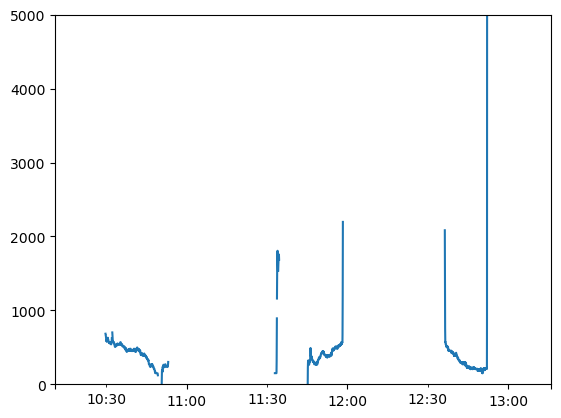

In [11]:
import halodataplot
# Radar reflectivity
processed_radar=halodataplot.replace_fill_and_missing_values_to_nan(
                                processed_radar,["dBZg","Zg",
                                                 "LDRg","VELg",
                                                 "radar_flag"])        
       
mlayer_height,low_ldr_df,ldr_cutted_df,bb_mask=find_melting_layer(processed_radar)
if do_plotting:
    mlayer_height.plot(ylim=[0,5000])

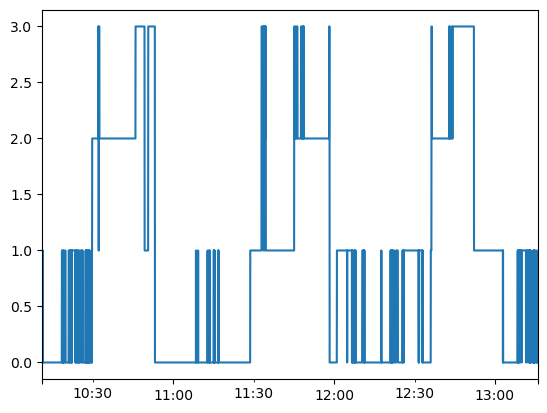

In [12]:
precip_type_series,zg_series=classify_precipitation_type(processed_radar,mlayer_height,bb_mask)
surface_mask=pd.Series(data=np.array(processed_radar["radar_flag"][:,0]),
                        index=pd.DatetimeIndex(np.array(processed_radar.time[:])))
if do_plotting:
    precip_type_series.plot()

In [13]:
surface_Ze=processed_radar["Zg"][:,4]
surface_Ze=surface_Ze.where(surface_Ze!=-888.)
ze_series=pd.Series(data=np.array(surface_Ze[:]),
                            index=pd.DatetimeIndex(
                               np.array(surface_Ze.time[:])))    
z_series_dict={}
z_series_dict["zg"]=zg_series
#z_series_dict["ze"]=ze_series
precipitation_rate=take_correct_precipitation_rates(z_series_dict,surface_mask,
                                                    precip_type_series,
                                                    z_for_snow=reflectivity_for_snow)
precip_rate_path=cmpgn_cls.campaign_data_path+"/data/precip_rates/"
precip_rate_file="Precip_rates_"+flight[0]+"_"+ar_of_day+".csv"
if not os.path.exists(precip_rate_path): os.mkdir(precip_rate_path)
precipitation_rate.to_csv(precip_rate_path+precip_rate_file)
print("Precip rates saved as:",precip_rate_path+precip_rate_file)

Precip rates saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\Work\GIT_Repository//HALO_AC3/data/precip_rates/Precip_rates_RF05_AR_entire_1.csv


Plotting HAMP Cloud Radar (processed and calibrated)
flag nans
flagging done
dBZ plotted
LDR plotted
Figure saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../plots/RF05_AR_entire_1_Rain_internal_calibrated_and_processed_radar_Z_g.png


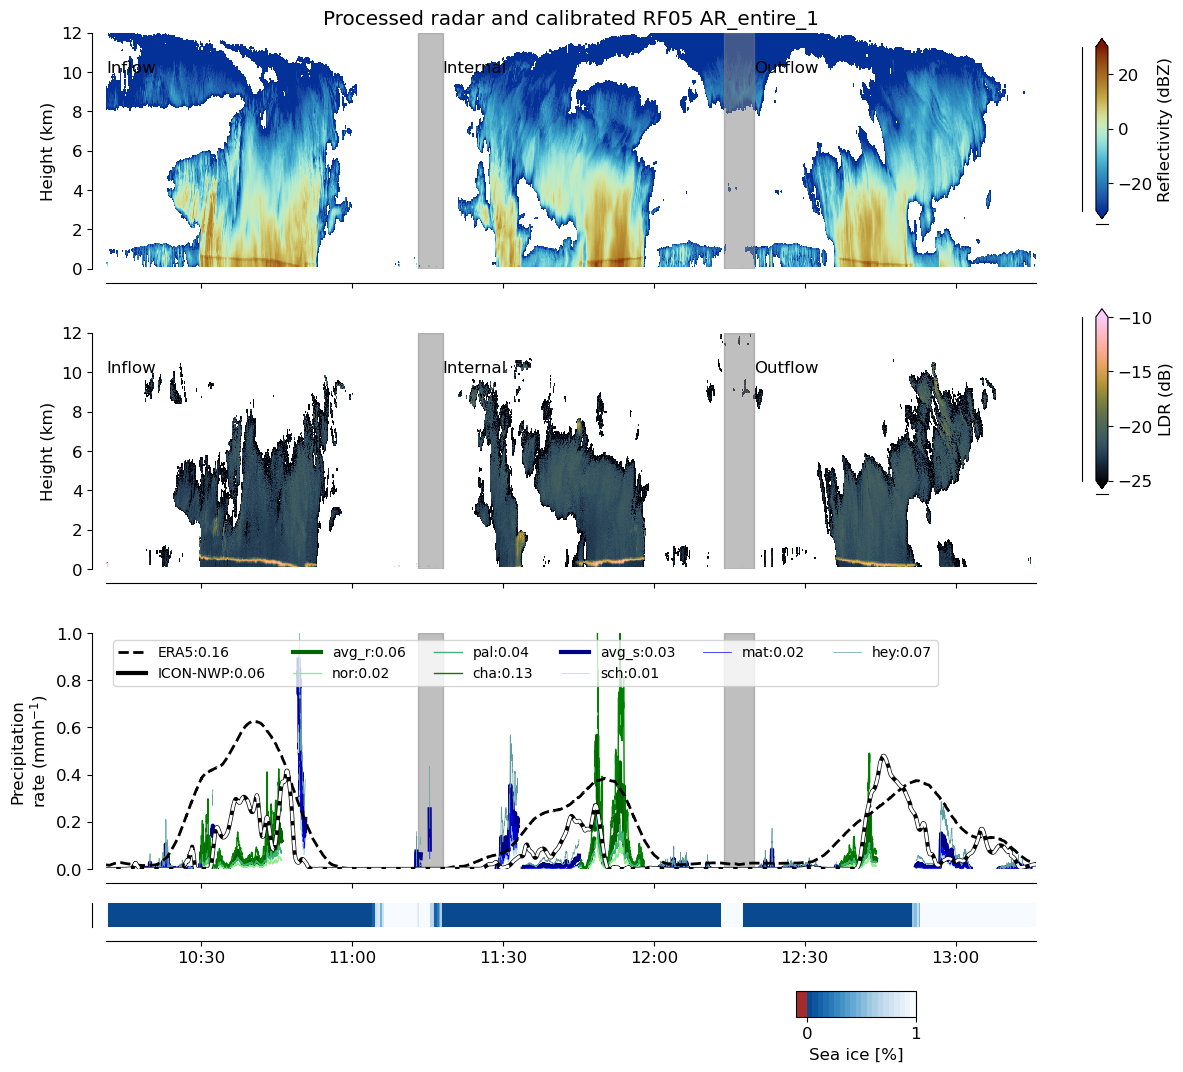

In [14]:
Radar_Plots=halodataplot.Radar_Quicklook(cfg_dict)
Radar_Plots.processed_radar=processed_radar
Radar_Plots.flight=flight
Radar_Plots.plot_path=plot_path
if do_plotting:
    radar_str=Radar_Plots.processed_radar_rain_rate(halo_era5,halo_icon_hmp,
                                  precipitation_rate,inflow_times,
                                  internal_times,outflow_times,ar_of_day,
                                  calibrated_radar=True,
                                  reflectivity_for_snow=reflectivity_for_snow)

Figure saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../plots/RF05_AR_entire_1_Only_Rain_internal_calibrated_and_processed_radar_Z_g.png


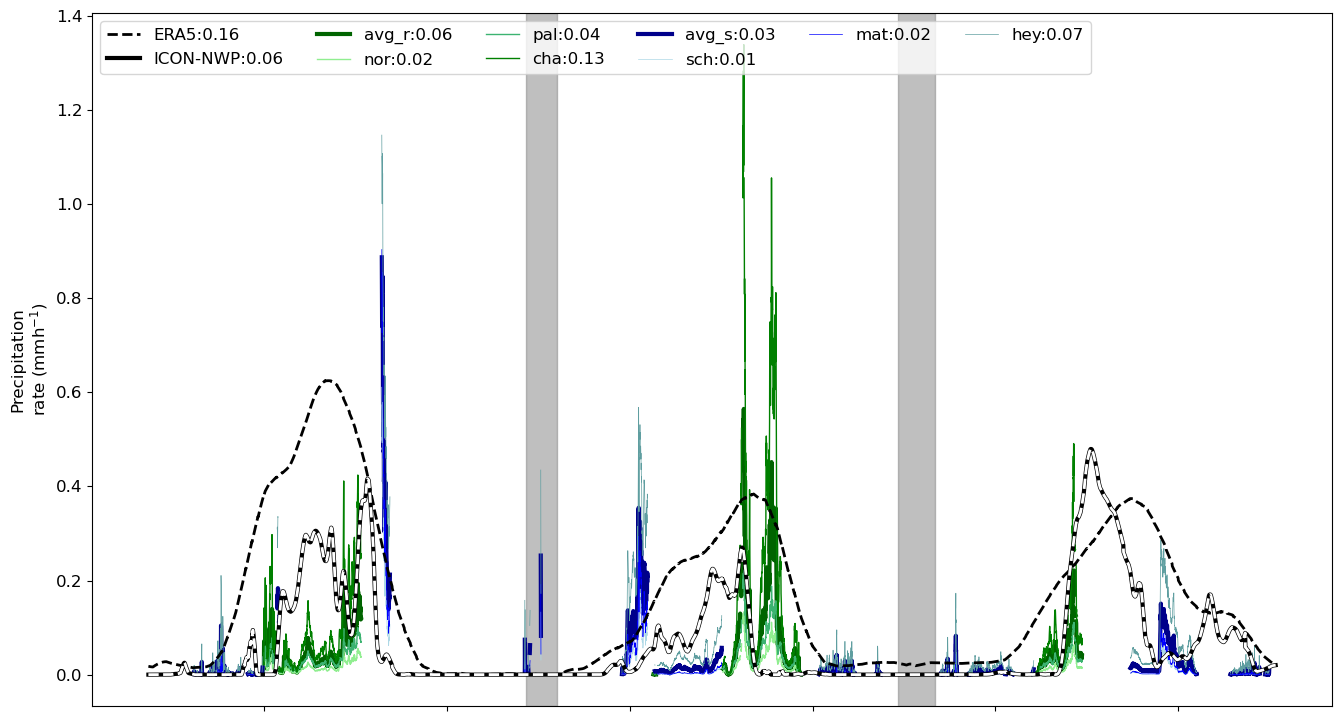

In [15]:
if do_plotting:
    Radar_Plots.plot_only_precip_rates(halo_era5,halo_icon_hmp,
                               precipitation_rate,ar_of_day,
                               inflow_times,internal_times,outflow_times,
                               radar_str,reflectivity_for_snow=reflectivity_for_snow)

In [16]:
# load hydrometeor ICON files for precipitation
if ar_of_day=="AR_entire_1":
    central_hour="12"
else:
    central_hour="14"
hydro_fpath=major_work_path+campaign+"/data/ICON_LEM_2km/"+flight[0]+"/"
hydro_file="Hydrometeor_ICON_"+flight[0]+"_"+ar_of_day+"_"+central_hour+"UTC.nc"
hydro_ds=xr.open_dataset(hydro_fpath+hydro_file)

In [17]:
temp_clat=np.rad2deg(pd.Series(hydro_ds.clat))
cutted_clat=temp_clat[temp_clat.between(halo_df["latitude"].min(),halo_df["latitude"].max())]
temp_clon=np.rad2deg(pd.Series(hydro_ds.clon))
temp_clon=temp_clon.loc[cutted_clat.index]
cutted_clon=temp_clon[temp_clon.between(halo_df["longitude"].min(),halo_df["longitude"].max())]
cutted_icon_precip=hydro_ds["hourly_prec"].isel(
                                ncells=cutted_clon.index)

precip_icon_series=pd.DataFrame(data=np.array(cutted_icon_precip.values[0,:]))

In [18]:
radar_precip_rate=pd.DataFrame(data=np.nan,index=precipitation_rate.index,
                               columns=["mean_snow","mean_rain","rate"])
radar_precip_rate["mean_snow"]=precipitation_rate["mean_snow"]
radar_precip_rate["mean_rain"]=precipitation_rate["mean_rain"]
radar_precip_rate=radar_precip_rate.fillna(0)
radar_precip_rate["rate"]=radar_precip_rate["mean_snow"]+radar_precip_rate["mean_rain"]

Figure saved as  C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../plots/RF05_AR_entire_1__Rain_rate_representativeness.png


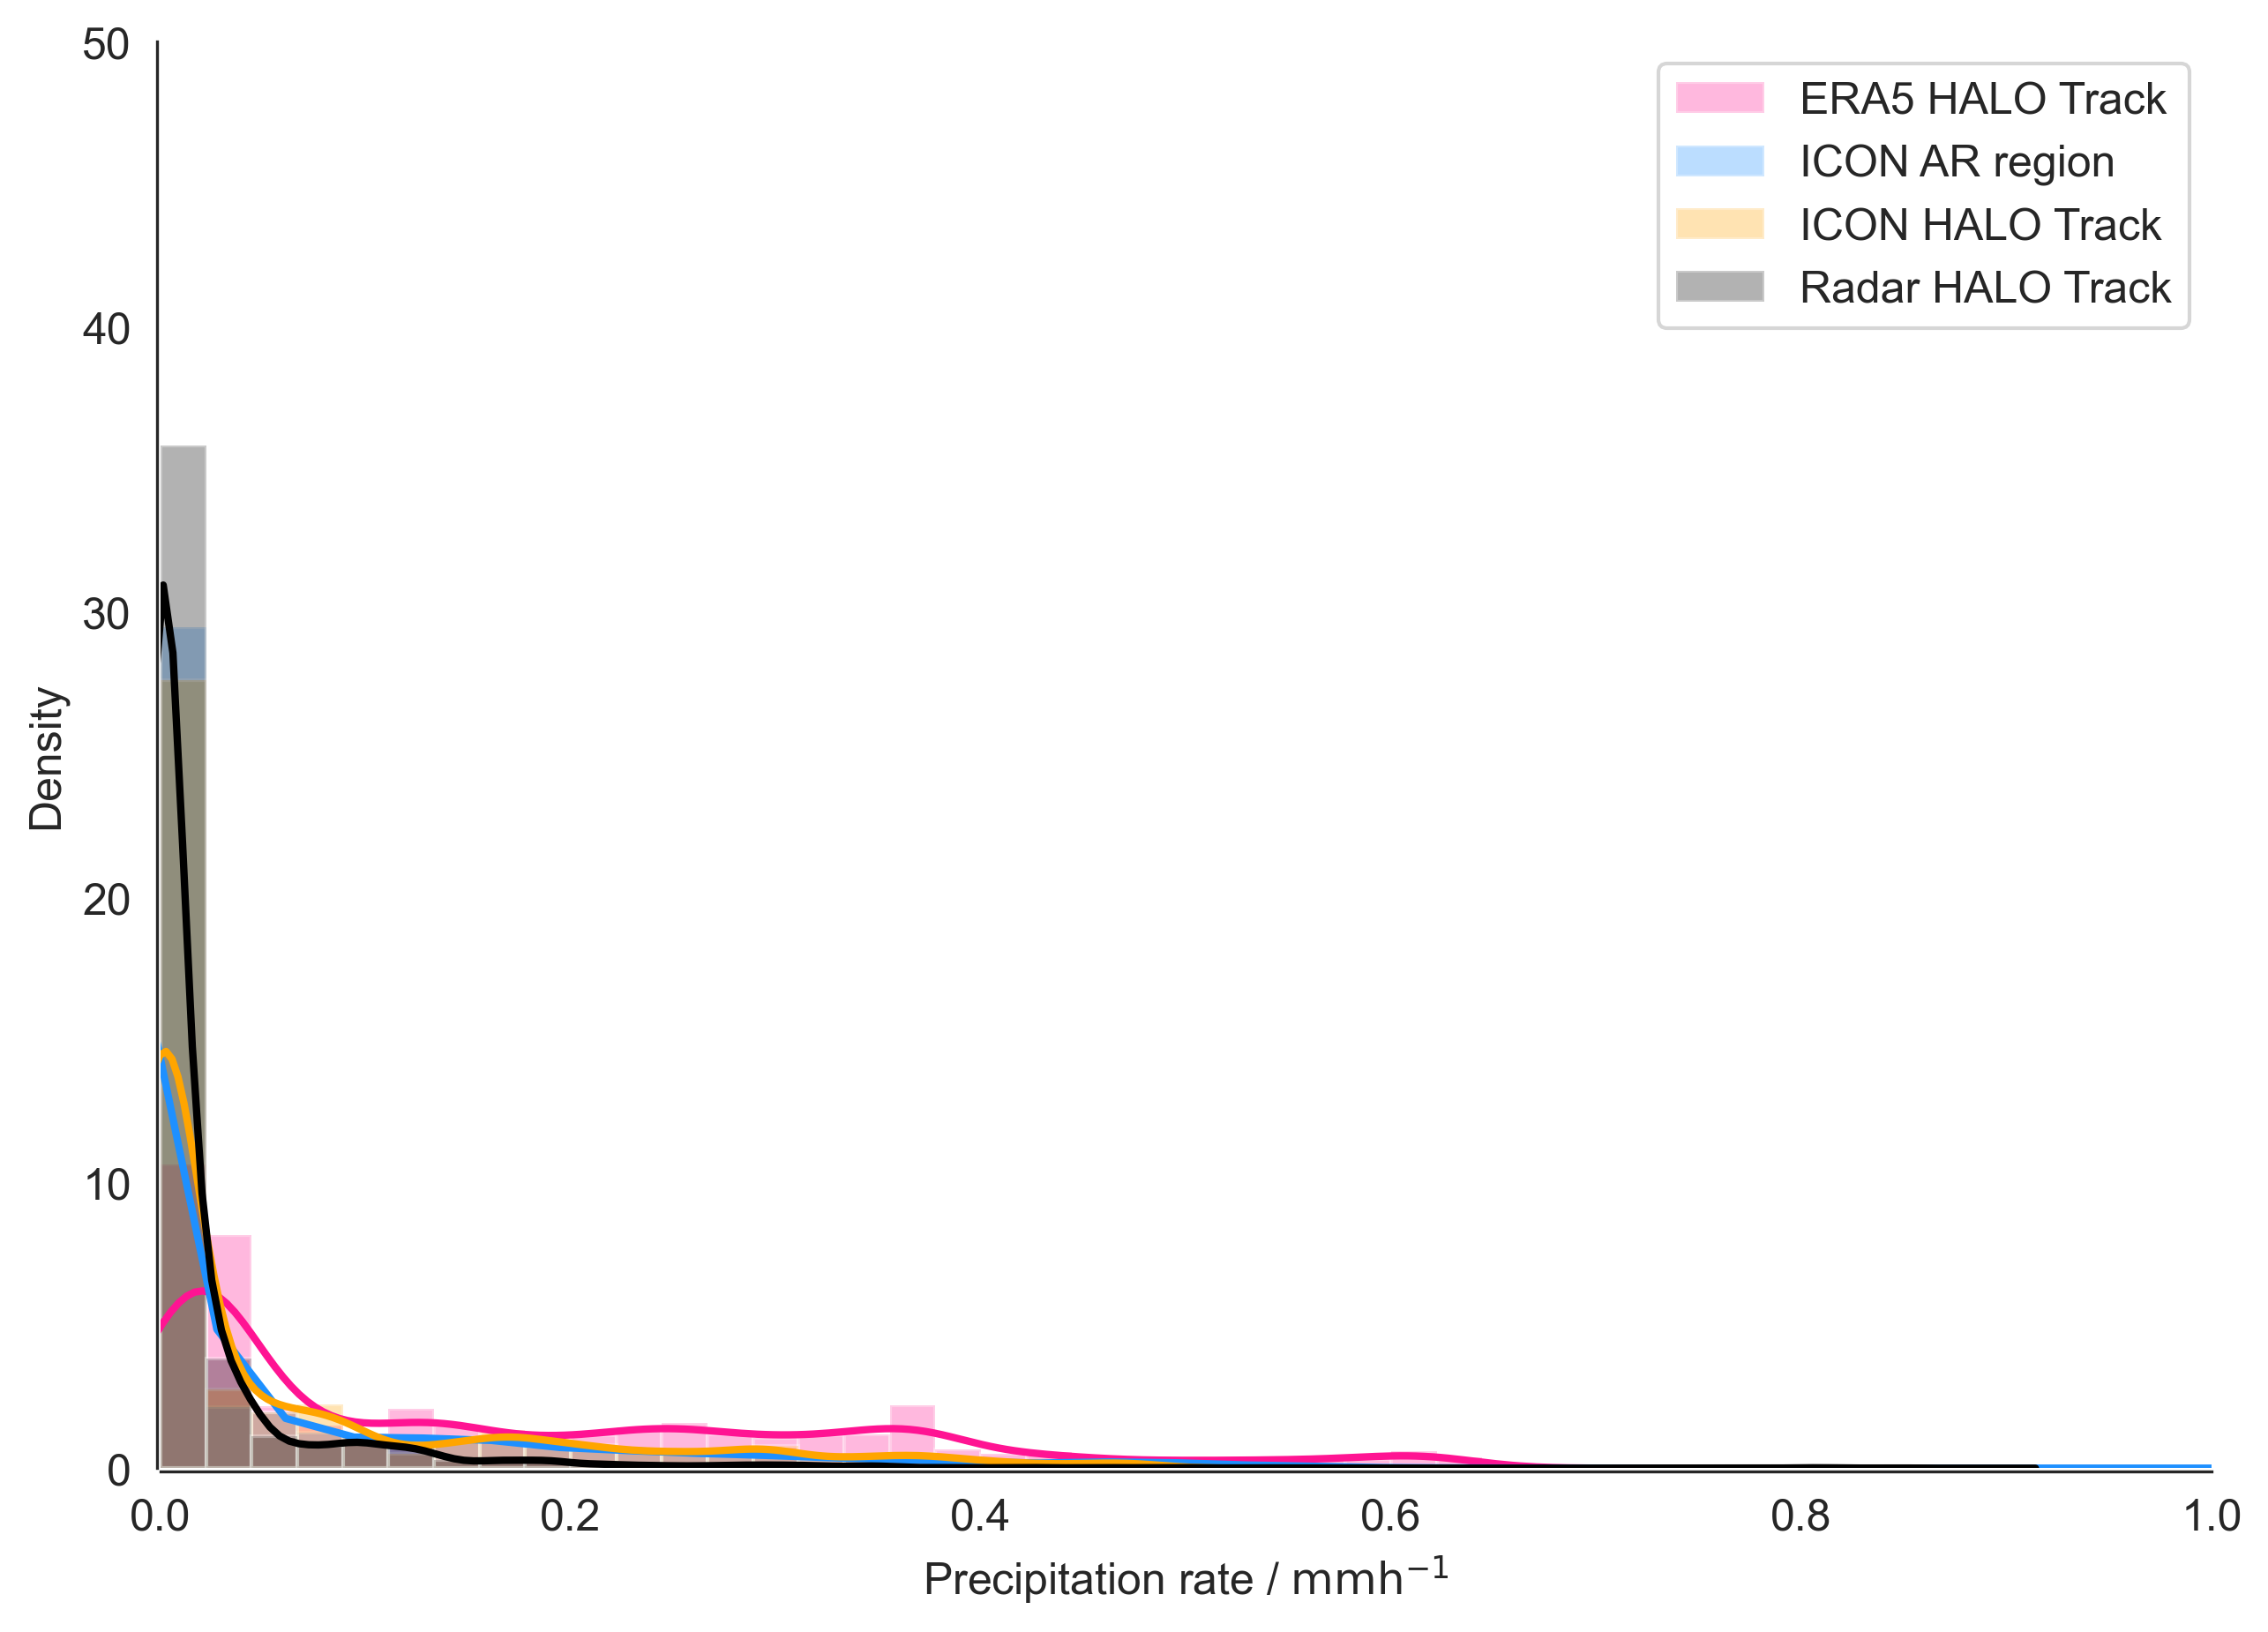

In [19]:
rain_distribution_comparison(precip_icon_series,halo_icon_hmp,halo_era5, radar_precip_rate,
                             flight,ar_of_day,"")

Create boxplot


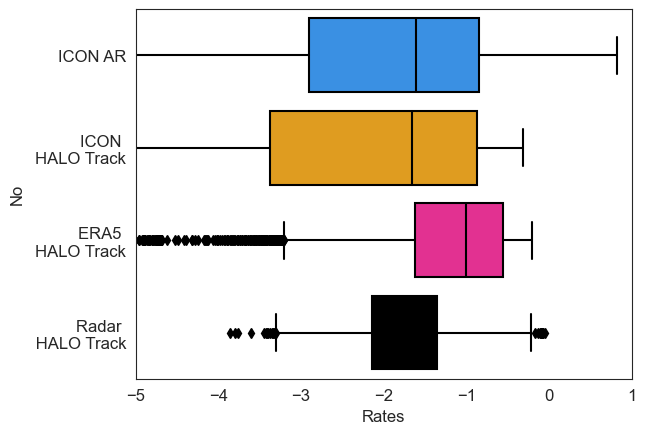

In [20]:
boxplot_precip_comparison(precip_icon_series,halo_icon_hmp,halo_era5, radar_precip_rate)
#radar_precip_rate

Figure saved as  C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../plots/RF05_AR_entire_1__Conditional_Rain_rate_representativeness.png


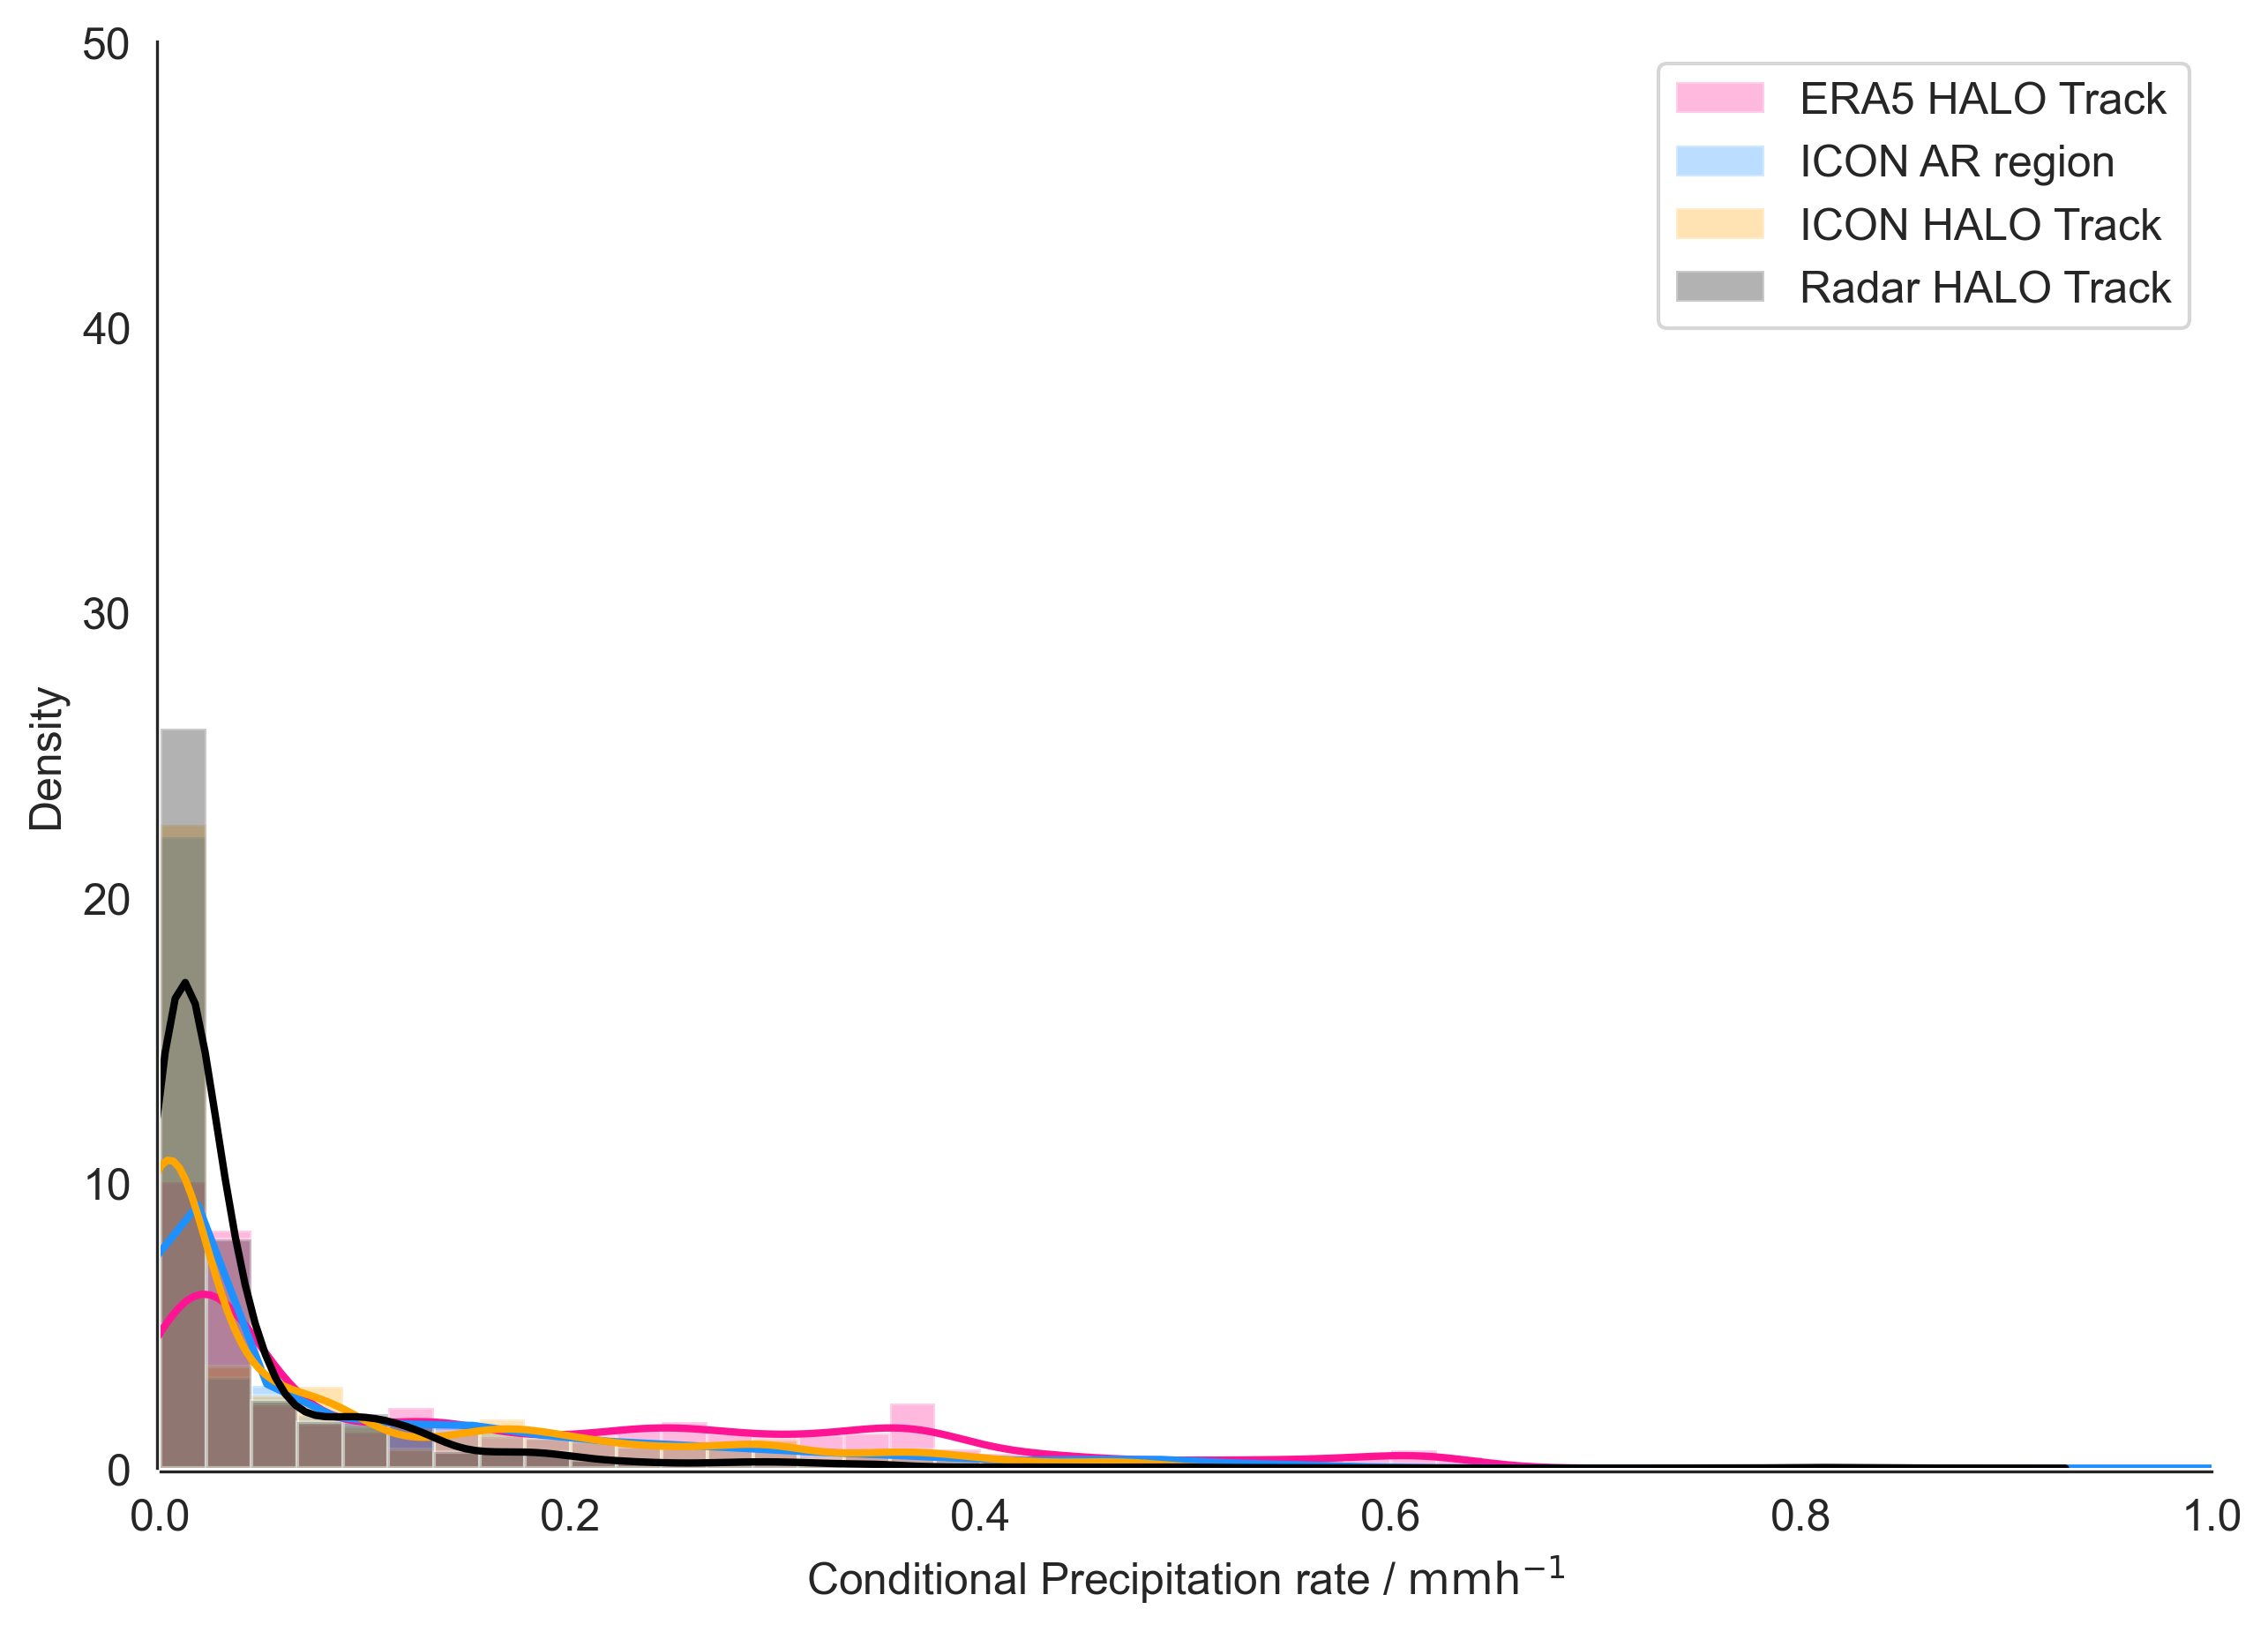

In [21]:
rain_distribution_comparison(precip_icon_series,halo_icon_hmp,halo_era5, radar_precip_rate,
                             flight,ar_of_day,"",conditional_dist=True)

In [22]:
#Dropsondes
take_arbitary=False
if not "Lat" in [*Dropsondes.keys()]:
    sondes_lon=[[*Dropsondes["reference_lon"].values()][sonde].data[0] \
                    for sonde in range(Dropsondes["IWV"].shape[0])]
                    
    sondes_lat=[[*Dropsondes["reference_lat"].values()][sonde].data[0]\
                    for sonde in range(Dropsondes["IWV"].shape[0])]
    Dropsondes["Lat"]=pd.Series(data=np.array(sondes_lat),
                                                index=Dropsondes["IWV"].index)
    Dropsondes["Lon"]=pd.Series(data=np.array(sondes_lon),
                                                index=Dropsondes["IWV"].index)

sonde_times_series=pd.Series(index=Dropsondes["IWV"].index.values,data=range(Dropsondes["IWV"].shape[0]))
relevant_sondes_dict={}

if take_arbitary:
    for sector in ["warm_sector","core","cold_sector","internal"]:
        print("Analyse frontal sector ",sector)
        AR_sector_in                       = AR_inflow["AR_inflow_"+sector]
        AR_sector_out                      = AR_outflow["AR_outflow_"+sector]
        
        relevant_sondes_dict[sector]       = {}
        relevant_sondes_dict[sector]["in"] = sonde_times_series.loc[AR_sector_in.index[0]:AR_sector_in.index[-1]]
        relevant_sondes_dict[sector]["out"]= sonde_times_series.loc[AR_sector_out.index[0]:AR_sector_out.index[-1]]
else:
    if flight[0]=="RF05":
        if ar_of_day=="AR_entire_1":
            relevant_warm_sector_sondes=[0,1,2,3,9,10,11,12]
            relevant_cold_sector_sondes=[4,5,6]
            relevant_internal_sondes=[7,8,13,14]
            relevant_sondes_dict["warm_sector"]        = {}
            relevant_sondes_dict["warm_sector"]["in"]  = sonde_times_series.iloc[relevant_warm_sector_sondes[0:4]]
            relevant_sondes_dict["warm_sector"]["out"] = sonde_times_series.iloc[relevant_warm_sector_sondes[4::]]
            relevant_sondes_dict["cold_sector"]        = {}
            relevant_sondes_dict["cold_sector"]["in"]  = sonde_times_series.iloc[relevant_cold_sector_sondes[0:3]]
            relevant_sondes_dict["cold_sector"]["out"] = sonde_times_series.iloc[relevant_cold_sector_sondes[3::]]
            relevant_sondes_dict["internal"]           = sonde_times_series.iloc[relevant_internal_sondes]
        elif ar_of_day=="AR_entire_2":
            relevant_warm_sector_sondes=[9,10,11,12,15,16,17,18]
            relevant_cold_sector_sondes=[19,20,21]
            relevant_sondes_dict["warm_sector"]        = {}
            relevant_sondes_dict["warm_sector"]["in"]  = sonde_times_series.iloc[relevant_warm_sector_sondes[4::]]
            relevant_sondes_dict["warm_sector"]["out"] = sonde_times_series.iloc[relevant_warm_sector_sondes[0:4]]
            relevant_sondes_dict["cold_sector"]        = {}
            relevant_sondes_dict["cold_sector"]["in"]  = pd.Series()#sonde_times_series.iloc[relevant_cold_sector_sondes[0:3]]
            relevant_sondes_dict["cold_sector"]["out"] = sonde_times_series.iloc[relevant_cold_sector_sondes]
    
    if flight[0]=="RF06":
        if ar_of_day=="AR_entire_1":
            relevant_warm_sector_sondes=[0,1,2,8,9,10]
            relevant_cold_sector_sondes=[3,4,5,10,11,12]
            relevant_warm_internal_sondes=[7,22]
            relevant_sondes_dict["warm_sector"]        = {}
            relevant_sondes_dict["warm_sector"]["in"]  = sonde_times_series.iloc[relevant_warm_sector_sondes[0:3]]
            relevant_sondes_dict["warm_sector"]["out"] = sonde_times_series.iloc[relevant_warm_sector_sondes[3:]]
            relevant_sondes_dict["cold_sector"]        = {}
            relevant_sondes_dict["cold_sector"]["in"]  = sonde_times_series.iloc[relevant_cold_sector_sondes[0:3]]
            relevant_sondes_dict["cold_sector"]["out"] = sonde_times_series.iloc[relevant_cold_sector_sondes[3:]]
            relevant_sondes_dict["internal"]           = sonde_times_series.iloc[relevant_warm_internal_sondes]
        elif ar_of_day=="AR_entire_2":
            relevant_warm_sector_sondes=[8,9,16,17]
            relevant_cold_sector_sondes=[10,11,12,18,19]
            relevant_warm_internal_sondes=[]
            relevant_sondes_dict["warm_sector"]        = {}
            relevant_sondes_dict["warm_sector"]["in"]  = sonde_times_series.iloc[relevant_warm_sector_sondes[0:2]]
            relevant_sondes_dict["warm_sector"]["out"] = sonde_times_series.iloc[relevant_warm_sector_sondes[2::]]
            relevant_sondes_dict["cold_sector"]        = {}
            relevant_sondes_dict["cold_sector"]["in"]  = sonde_times_series.iloc[relevant_cold_sector_sondes[0:3]]
            relevant_sondes_dict["cold_sector"]["out"] = sonde_times_series.iloc[relevant_cold_sector_sondes[3::]]
# -----> Location information to define the ICON rectangle box around that considers internal precipitation
### Cold sector sondes
#{'cold':                       Halo_Lat   Halo_Lon             dx             dy
# 2022-03-15 10:49:06  72.492348  -9.048471   18458.090409 -252652.694003
# 2022-03-15 10:55:47  72.644676 -11.746952  -68593.693059 -235814.302585
# 2022-03-15 11:03:29  72.776390 -14.936958 -170872.503778 -221254.651706
# 2022-03-15 12:55:00  76.801040  -4.658210  203077.456609  223630.119711
# 2022-03-15 13:05:00  76.952997  -9.839518   74207.822114  240427.441735
# 2022-03-15 13:15:00  77.000370 -15.085639  -56277.172294  245664.086848


# Warm sector sondes
#{'warm':                       Halo_Lat  Halo_Lon             dx             dy
# 2022-03-15 10:19:22  71.412415  2.119259   57426.540578 -294932.867661
# 2022-03-15 10:28:33  71.809677 -1.153413  -57855.149678 -251019.462814
# 2022-03-15 10:34:37  72.042000 -3.403830 -134599.374441 -225338.512344
# 2022-03-15 10:41:45  72.284691 -6.153736 -226219.905006 -198511.444778
# 2022-03-15 12:28:34  75.933517  8.080936  200865.746408  204829.847488
# 2022-03-15 12:36:29  76.259956  4.442734   99695.073834  240914.403915
## 2022-03-15 12:40:08  76.391243  2.720047   53472.408266  255426.827011
# 2022-03-15 12:43:47  76.510696  0.962272    7214.660040  268631.209183}
#{'warm':                       Halo_Lat   Halo_Lon             dx             dy
        # 2022-03-16 10:46:57  71.144676  17.200075   90276.849633 -115494.138234
        # 2022-03-16 10:56:15  71.200279  13.740361  -35595.821300 -109347.779592
        # 2022-03-16 11:03:35  71.197830  11.011759 -133432.507410 -109618.495992
        # 2022-03-16 12:13:00  72.973465  21.382162  168456.503395   86660.171000
        # 2022-03-16 12:21:11  73.190468  18.015015   51433.721131  110647.668101
        # 2022-03-16 12:35:11  73.430244  12.202295 -141138.745448  137152.574717}
        
warm_lon_min_max=[0,0]
warm_lat_min_max=[0,0]

In [23]:
#halo_icon_hmp

In [24]:
radar_precip_rate["lat"]=halo_df["latitude"].loc[radar_precip_rate.index]
radar_precip_rate["lon"]=halo_df["longitude"].loc[radar_precip_rate.index]#radar_precip_rate

Figure saved as  C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../plots/RF05_AR_entire_1_warm_Map_box_precipitation


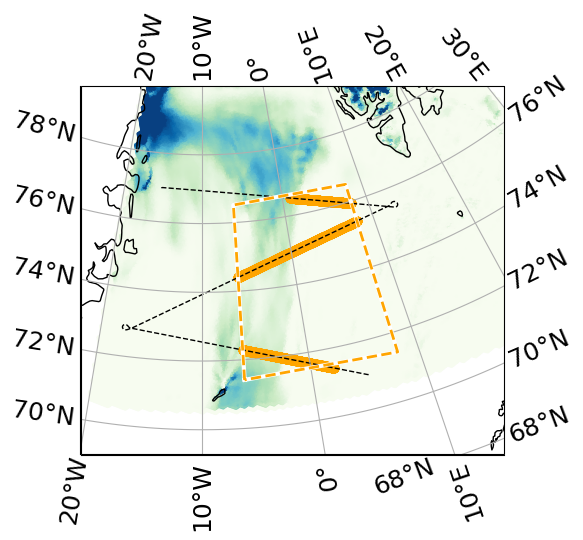

In [41]:
# radar sector
if flight[0]=="RF05":
    if ar_of_day=="AR_entire_1":
        warm_radar_rain=radar_precip_rate.loc[radar_precip_rate["lat"].between(71.412415,76.510696)]
        warm_radar_rain=warm_radar_rain.loc[warm_radar_rain["lon"].between(-6.153736,8.080936)]
        cold_radar_rain=radar_precip_rate.loc[radar_precip_rate["lat"].between(72.492348,77.000370)]
        cold_radar_rain=radar_precip_rate.loc[radar_precip_rate["lon"].between(-15.085639,-4.658210)]
    elif ar_of_day=="AR_entire_2":
        warm_radar_rain=radar_precip_rate.loc[radar_precip_rate["lat"].between(72.850830,76.510696)]
        warm_radar_rain=warm_radar_rain.loc[warm_radar_rain["lon"].between(-4.379189,8.080936)]
    else:
        Exception("no other AR sector defined")# apply sector to icon
elif flight[0]=="RF06":
    if ar_of_day=="AR_entire_1":
        warm_radar_rain=radar_precip_rate.loc[radar_precip_rate["lat"].between(71.144676,73.430244)]
        warm_radar_rain=warm_radar_rain.loc[warm_radar_rain["lon"].between(11.011759,21.382162)]
    elif ar_of_day=="AR_entire_2":
        warm_radar_rain=radar_precip_rate.loc[radar_precip_rate["lat"].between(72.973465,75.811005)]
        warm_radar_rain=warm_radar_rain.loc[warm_radar_rain["lon"].between(18.015015,25.683155)]
        
warm_icon_rain=halo_icon_hmp.loc[warm_radar_rain.index]
warm_icon_rain["rate"]=warm_icon_rain["Interp_Precip"]
try:
    cold_icon_rain=halo_icon_hmp.loc[cold_radar_rain.index]
    cold_icon_rain["rate"]=cold_icon_rain["Interp_Precip"]
except:
    print("No cold sector available")
map_precipitation_region(hydro_ds,processed_radar,halo_df,warm_radar_rain,plot_path,sector="warm")

Create boxplot
Figure saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../plots/Boxplot_Precip_representativeness.png


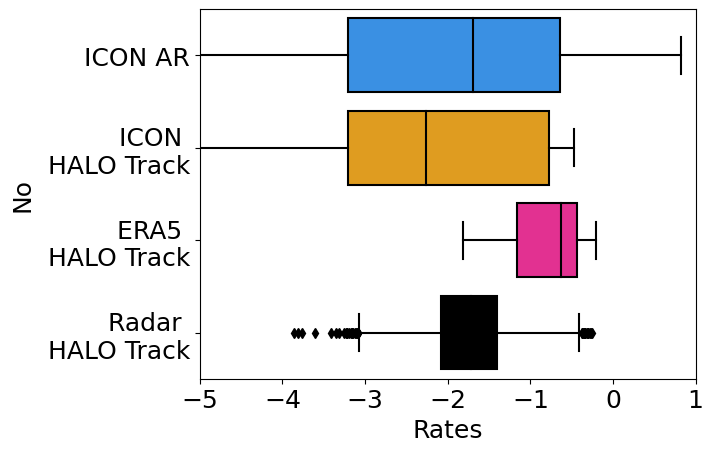

In [64]:
#flight="RF06"
#campaign="HALO_AC3"
#ar_sector="AR_entire_2"
#add_hydrometeors=True
#ICON_HALO_AC3=ICON_NWP_HALO_AC3(flight,campaign,ar_sector,add_hydrometeors=add_hydrometeors)
hydro_ds["hourly_prec"]
#warm_icon_rain["rate"]
#warm_radar_rain["rate"]
boxplot_precip_comparison(pd.Series(data=hydro_ds["hourly_prec"].values[0,:]),
                          halo_icon_hmp.loc[warm_radar_rain.index],halo_era5.loc[warm_radar_rain.index], warm_radar_rain,plot_path)

In [26]:
#describe warm rain rate
warm_precip_file_name="warm_precip_"+flight[0]+"_"+ar_of_day+".csv"
warm_radar_rain.to_csv(precip_rate_path+warm_precip_file_name)
print("Warm rain saved as:",precip_rate_path+warm_precip_file_name)
try:
    cold_precip_file_name="cold_precip_"+flight[0]+"_"+ar_of_day+".csv"
    cold_radar_rain.to_csv(precip_rate_path+cold_precip_file_name)
    print("Cold rain saved as:",precip_rate_path+cold_precip_file_name)
except:
    "No cold sector available"

Warm rain saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\Work\GIT_Repository//HALO_AC3/data/precip_rates/warm_precip_RF05_AR_entire_1.csv
Cold rain saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\Work\GIT_Repository//HALO_AC3/data/precip_rates/cold_precip_RF05_AR_entire_1.csv


### Rain fraction

In [27]:
## Radar
print("Radar pre-frontal rain fraction:",warm_radar_rain.loc[warm_radar_rain["rate"]>0.0].shape[0]/warm_radar_rain.shape[0])
try:
    print("Radar post-frontal rain fraction:",cold_radar_rain.loc[cold_radar_rain["rate"]>0.0].shape[0]/cold_radar_rain.shape[0])
except:
    print("Radar post-frontal rain fraction not defined")

Radar pre-frontal rain fraction: 0.7970535941071882
Radar post-frontal rain fraction: 0.48146353283256604


In [28]:
print("ICON pre-frontal rain fraction:",warm_icon_rain.loc[warm_icon_rain["rate"]>0.0].shape[0]/warm_icon_rain.shape[0])
try:
    print("ICON post-frontal rain fraction:",cold_icon_rain.loc[cold_icon_rain["rate"]>0.0].shape[0]/cold_icon_rain.shape[0])
except:
    print("ICON post-frontal rain fraction not defined")

ICON pre-frontal rain fraction: 0.9029718059436119
ICON post-frontal rain fraction: 0.8560697843469833


Create boxplot
Figure saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../plots/Rain_rate_Statistics_RF05_warm_calibrated_and_processed_radar_Z_g.png


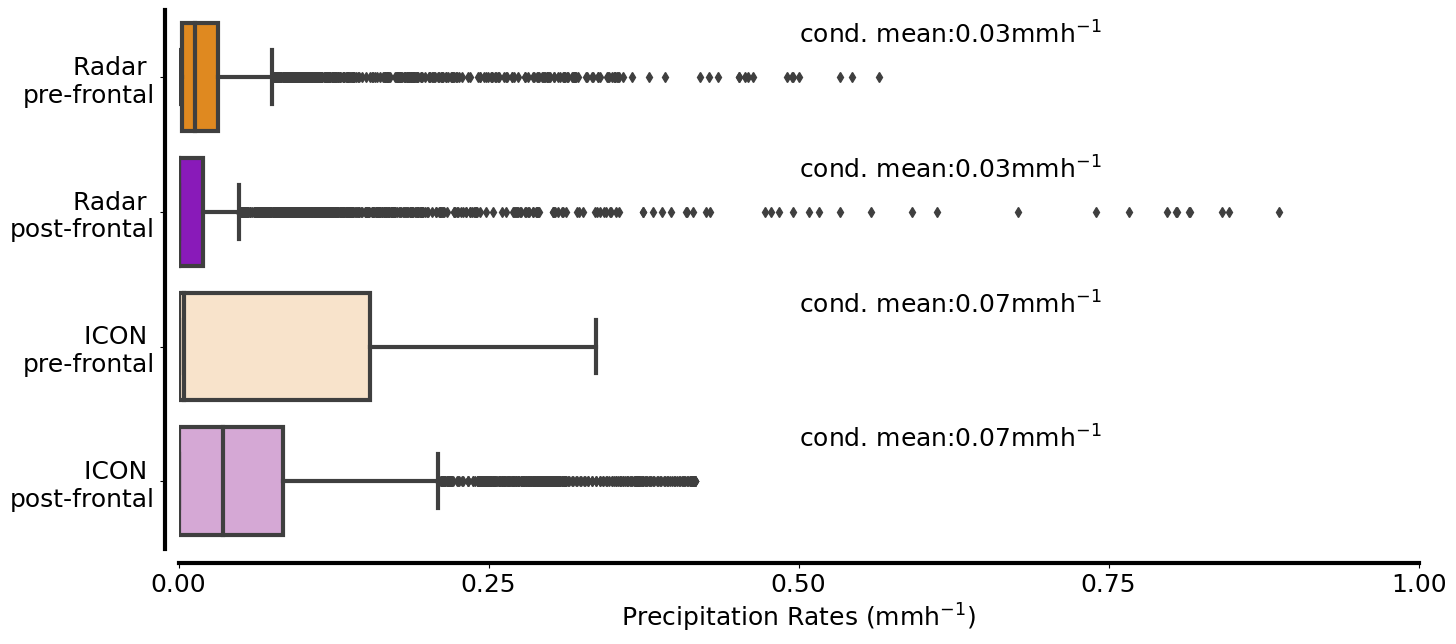

In [36]:
plot_frontal_sector_radar_icon_rain_comparison(
                    warm_radar_rain,cold_radar_rain,
                    warm_icon_rain,cold_icon_rain,plot_path)

Create boxplot
Figure saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../plots/Conditional_Rain_rate_Statistics_RF05_warm_calibrated_and_processed_radar_Z_g.png


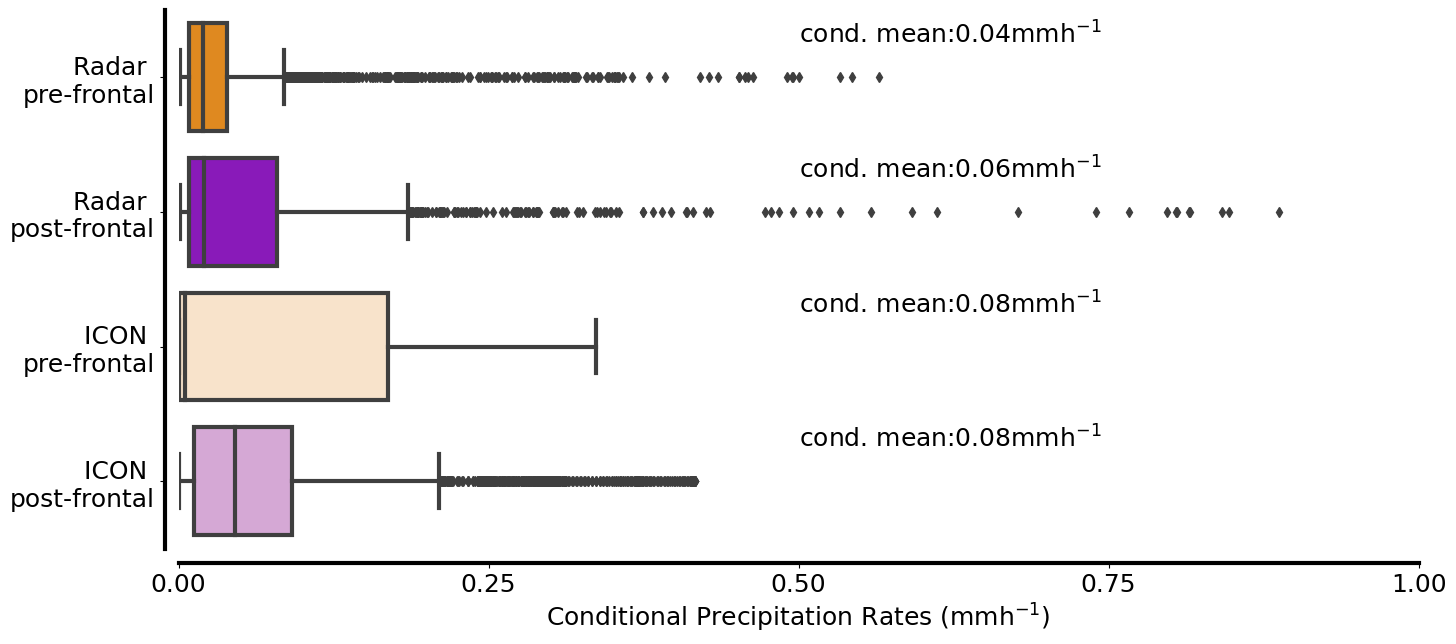

In [37]:
plot_frontal_sector_radar_icon_rain_comparison(
                    warm_radar_rain,cold_radar_rain,
                    warm_icon_rain,cold_icon_rain,plot_path,do_conditional=True)

Figure saved as  C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../plots/RF05_AR_entire_1_warm_Conditional_Rain_rate_representativeness.png


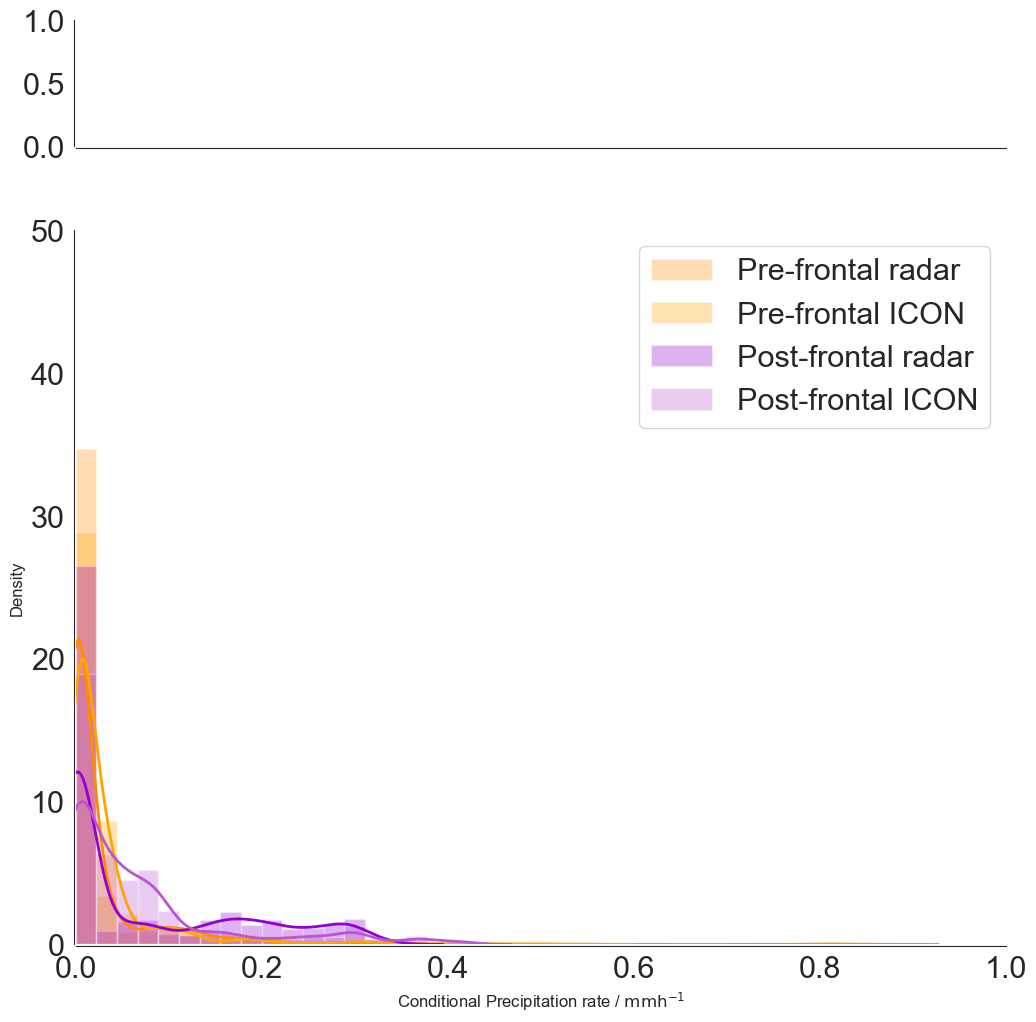

In [30]:
sector_rain_halo_icon_comparison(warm_radar_rain,cold_radar_rain,warm_icon_rain,cold_icon_rain,flight,ar_of_day,sector_to_plot,plot_path)

### 3D Flight Overview

Figure saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../plots/RF05_AR_IWV_IVT_Track_Map_with_sondes.png


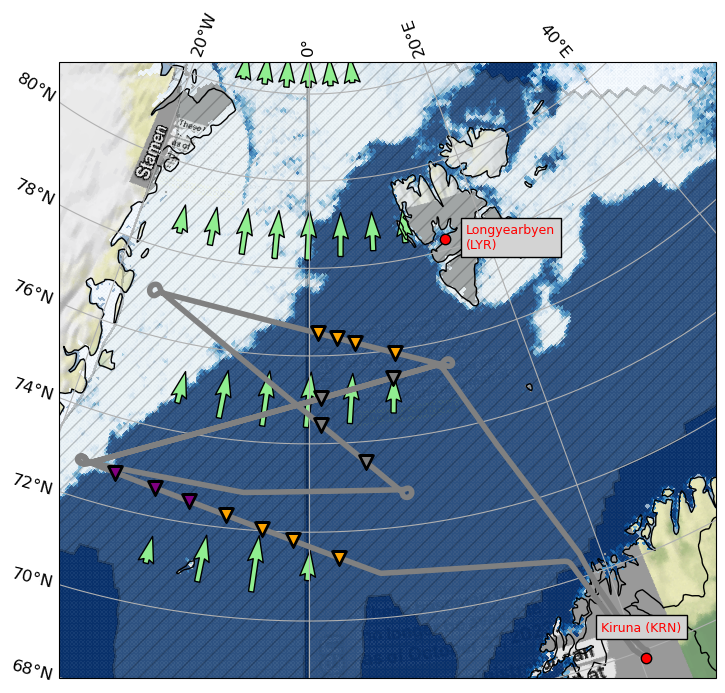

In [31]:
map_AR_sea_ice(cfg_dict,radar_ds,ds)

Figure saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../plots/RF05_Budget_Area.png


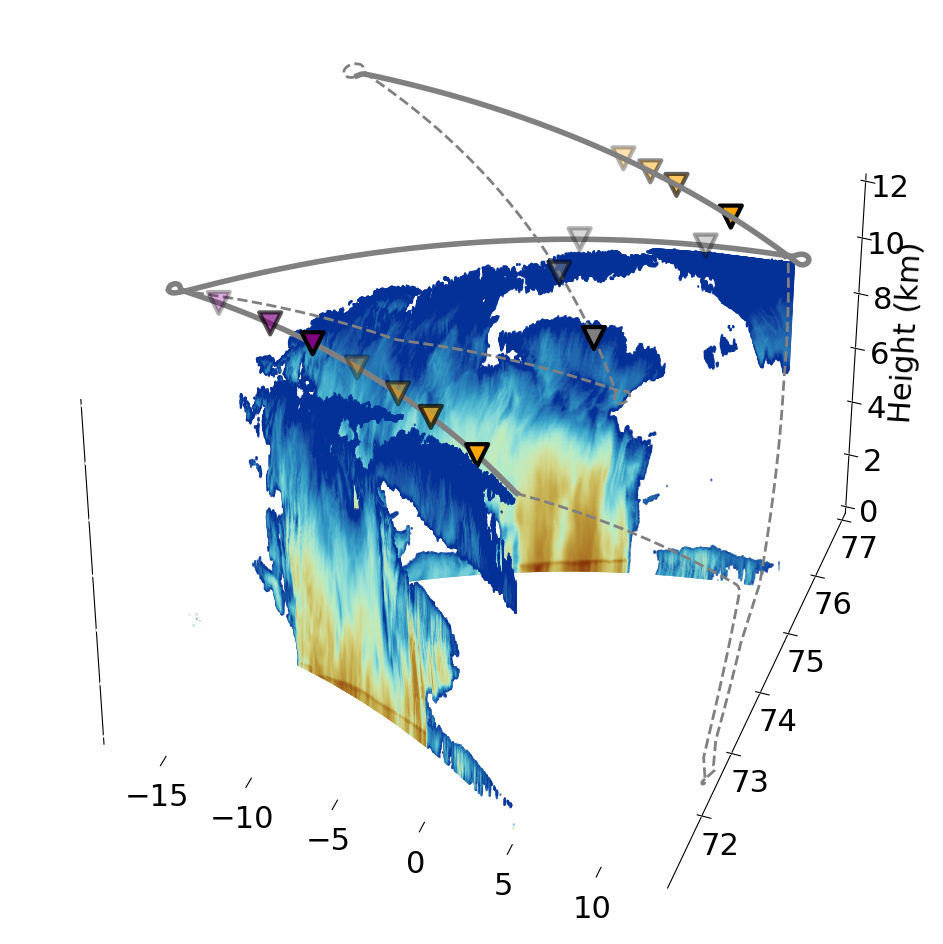

In [32]:
map_3d_radar_view(processed_radar,Dropsondes,plot_path)